In [4]:
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.torch_generic_model_training import train_model_with_cv
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [7]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [8]:
dataset_raw_train, dataset_raw_test = split(NumpyDataset(data_raw, labels), test_size_pct=0.2, seed=6942066)

### Create sequences

In [9]:
sequences_ds_train = combine_birds(
    dataset_raw_train, 
    sequence_length=300,
    random_seed=42
)
print(f'{sequences_ds_train.data.shape = }')
print(f'{sequences_ds_train.labels.shape = }')

Creating random sequence (num_duplicates = 1): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96000/96000 [01:06<00:00, 1447.38it/s]

sequences_ds_train.data.shape = (320, 300, 548)
sequences_ds_train.labels.shape = (320, 300)


In [10]:
sequences_ds_test = combine_birds(
    dataset_raw_test, 
    sequence_length=300,
    random_seed=42
)
print(f'{sequences_ds_test.data.shape = }')
print(f'{sequences_ds_test.labels.shape = }')

Creating random sequence (num_duplicates = 1): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24000/24000 [00:04<00:00, 5432.67it/s]

sequences_ds_test.data.shape = (80, 300, 548)
sequences_ds_test.labels.shape = (80, 300)


# Hyper Parameters

In [11]:
ac_hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    attention_window_size=30,
    d_model=60,
    num_heads=12,
    attention_stack_size=1,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.45,
    
    in_linear_hidden_out_features=[64, 48],
    out_linear_hidden_out_features=[24, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [12]:
def create_training_hyper_parameters(
    num_epochs: Union[int, float], 
    initial_lr: float,
    lr_scheduler_milestones: list[Union[int, float]],
    lr_scheduler_gamma: float
):
    return TrainingHyperParameters(
        batch_size=32,
        
        loss_weight_factors=torch.Tensor([
            1.0 / 1.35, # 0
            1.0, # 1
            1.0 / 1.5, # 2
            1.0, # 3
            1.0, # 4
            1.0, # 5
            1.0, # 6
        ]).to(device),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(num_epochs),
        
        lr=initial_lr,
        lr_scheduler_milestones=[int(m) for m in lr_scheduler_milestones],
        lr_scheduler_gamma=lr_scheduler_gamma,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
        # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
        #     optimizer, 
        #     milestones=milestones,
        #     gamma=gamma
        # )
    )

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                                                                                                                | 0/8 [00:00<?, ?it/s]




Executing CV for fold 0
Training fold 0


#### Training ####
##################
AttentionClassifier with 57819 parameters, in_fnn: 41196, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [59904,  4134,  6065,  5655,  1709,  3788,  2745]
train label counts = [ 8462,   480,  1060,   909,   219,   373,   497]

loss weights                    = [ 0.74, 14.49,  6.58, 10.59, 35.05, 15.81, 21.82]
eval loss weights (theoretical) = [ 0.74, 17.63,  5.32,  9.31, 38.64, 22.69, 17.03]


Training Epoch   1/200: lr = 1.00E-03, epoch =     1, avg_loss = 0.000208, num_samples = 84000, num_correct =  2059, acc = 0.024512, bacc = 0.141109, score = -0.448846
Evaluation Epoch   1/200: epoch =     1, avg_loss = 0.000345, num_samples = 12000, num_correct =   271, acc = 0.022583, bacc = 0.135911, score = -0.441317
Training Epoch   2/200: lr = 1.00E-03, epoch =     2, avg_loss = 0.000208, num_samples = 84000, num_correct =  1750, acc = 0.020833, bacc = 0.141741, score = -0.4601

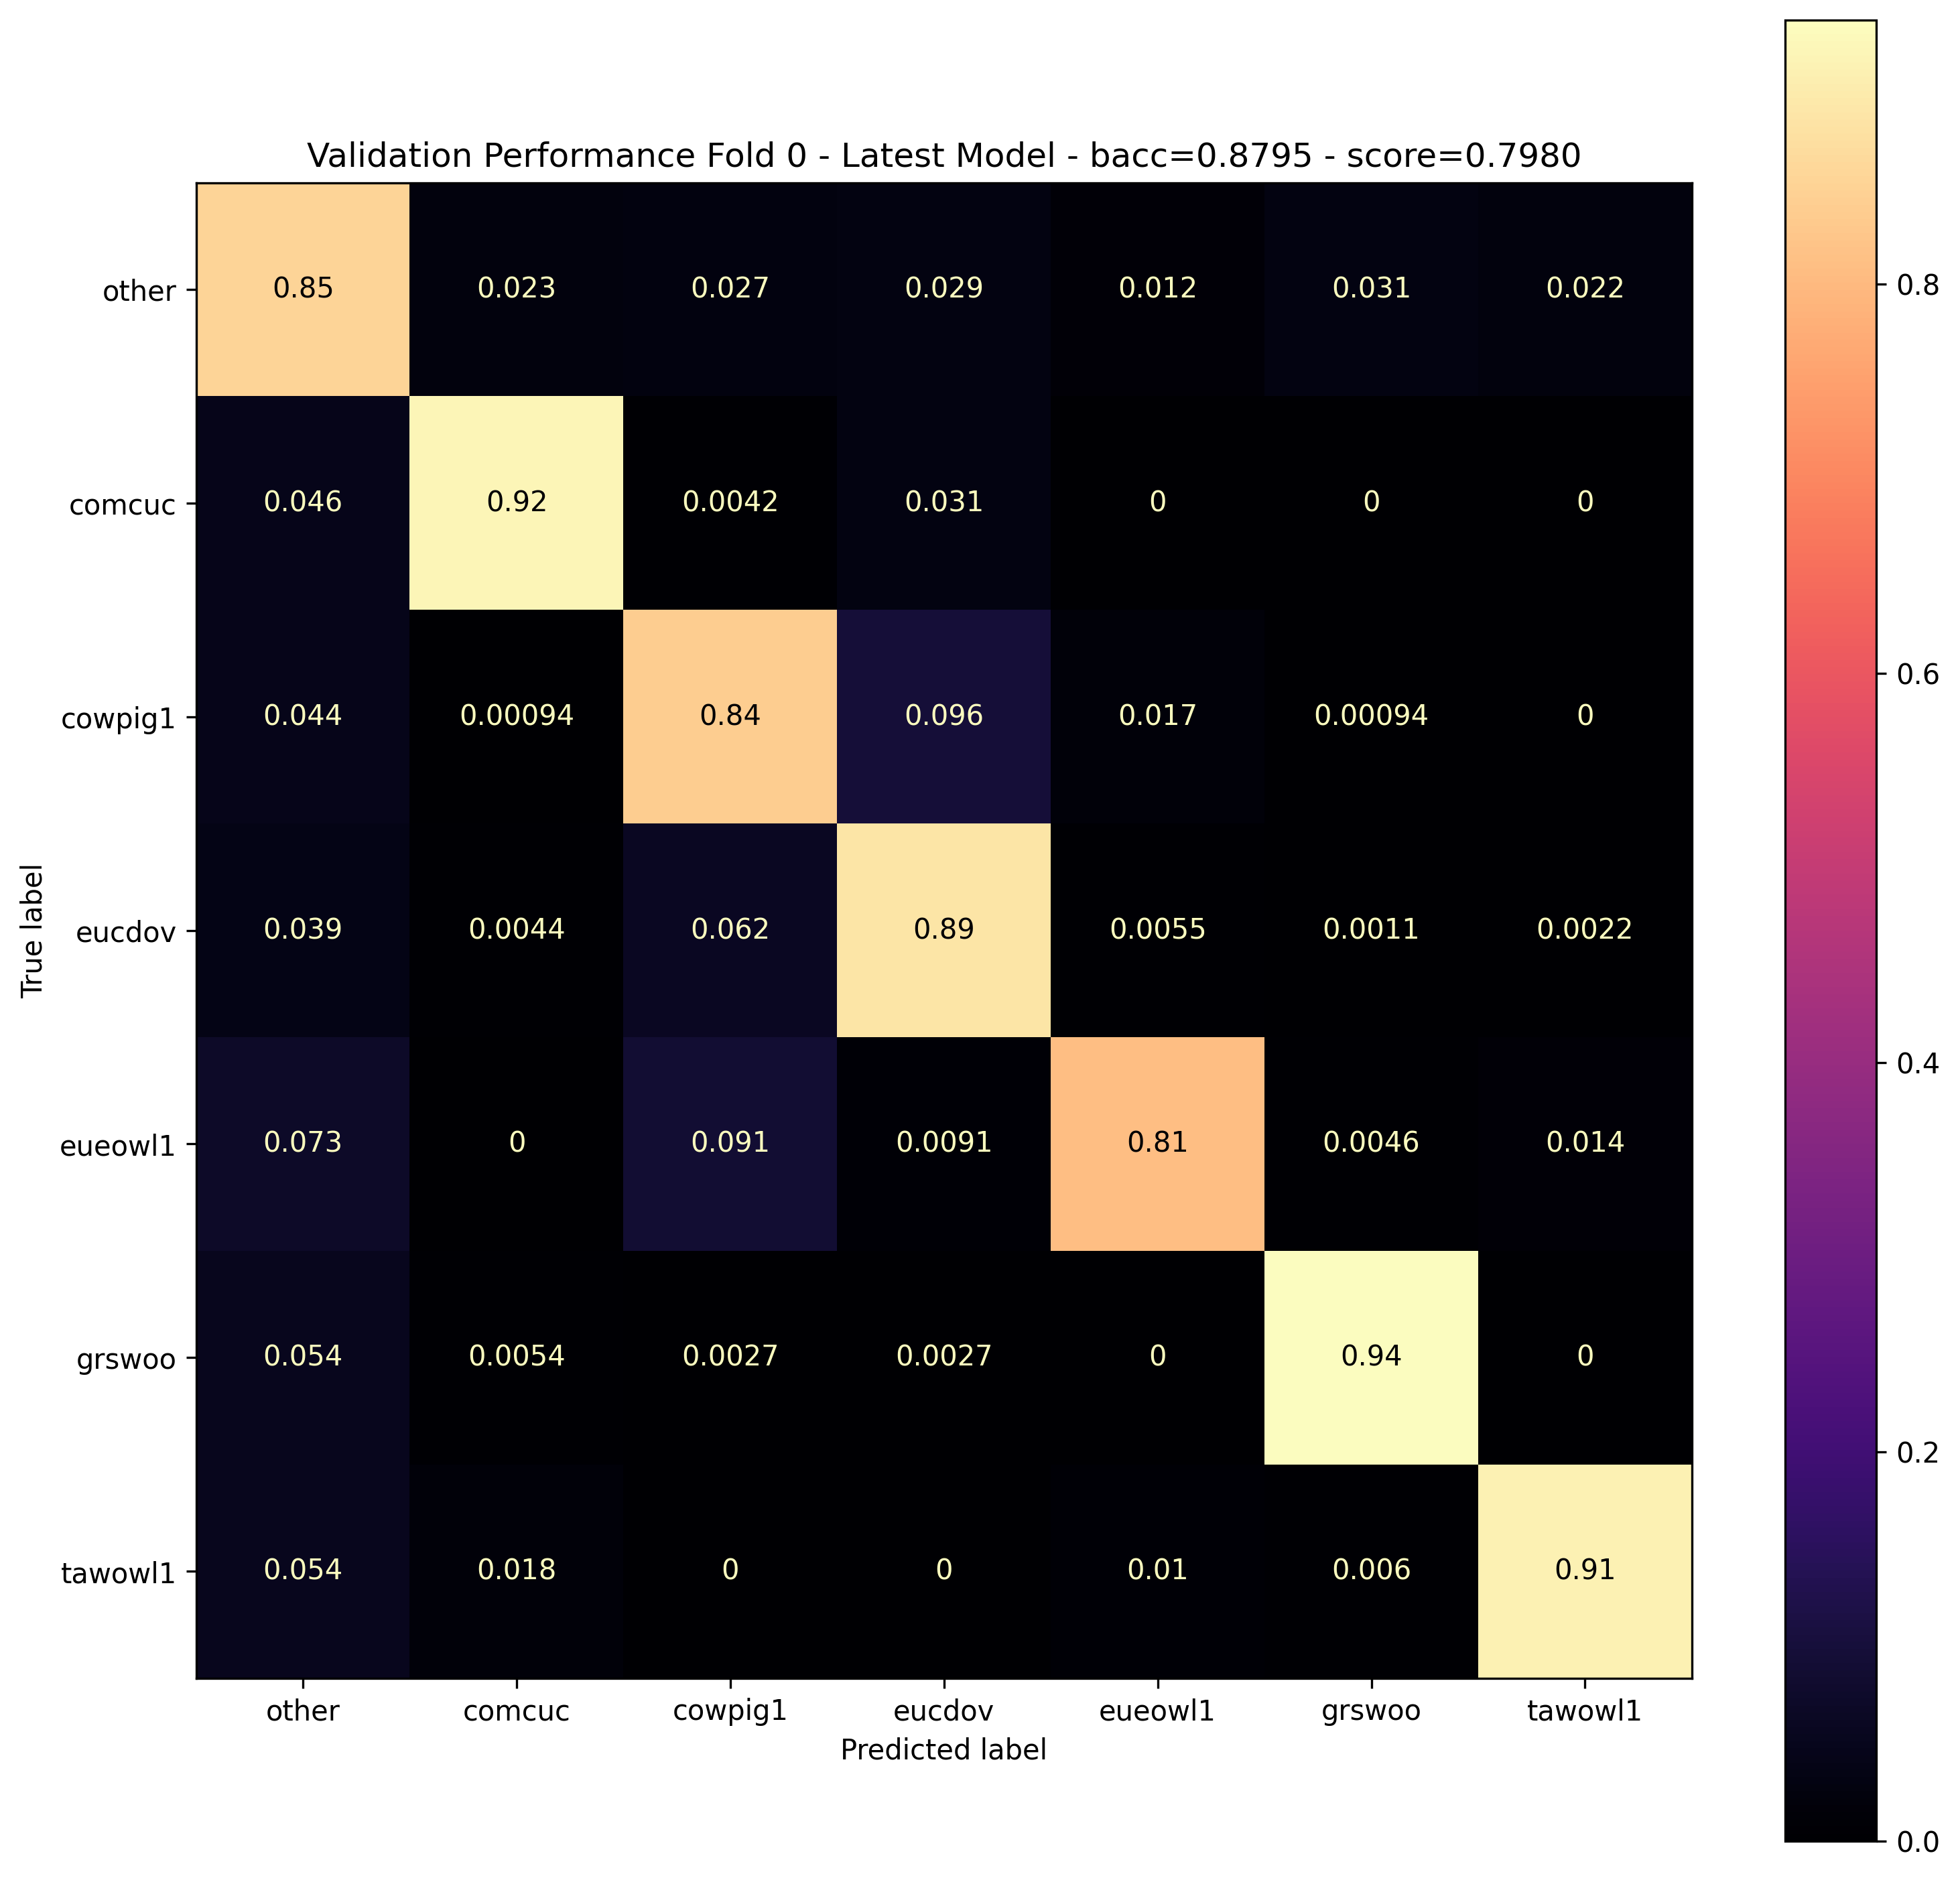

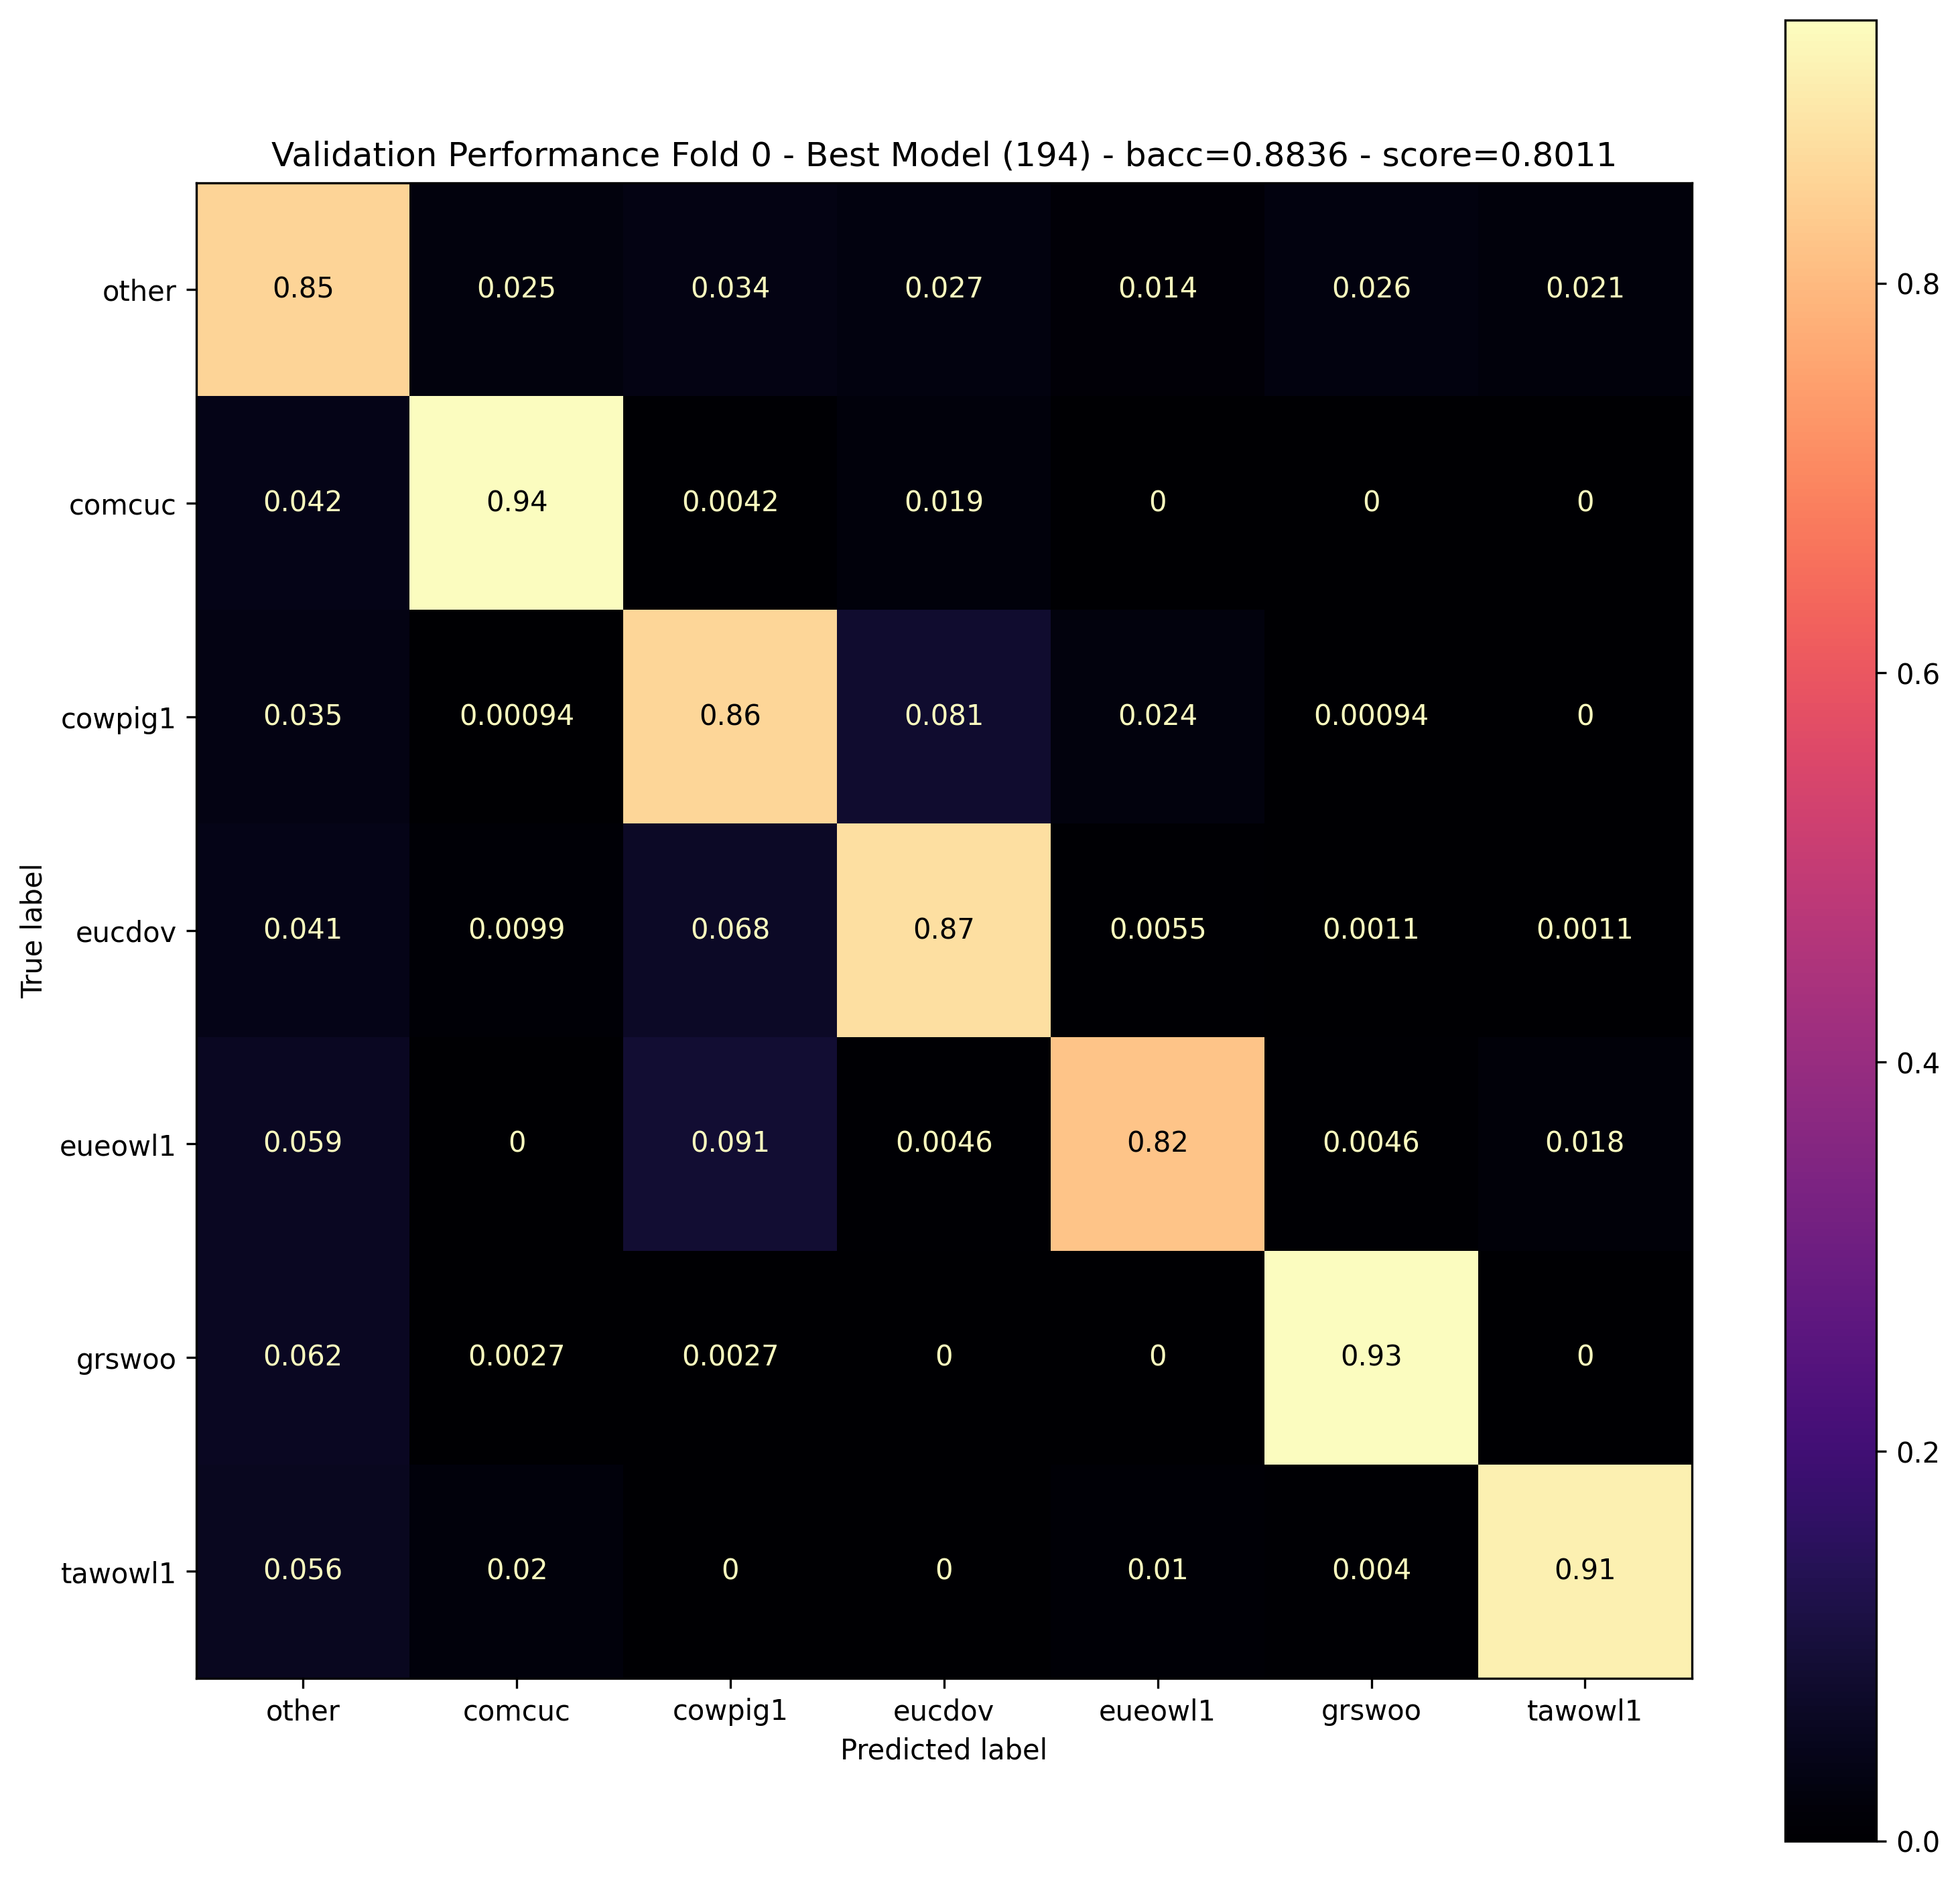


Testing fold 0


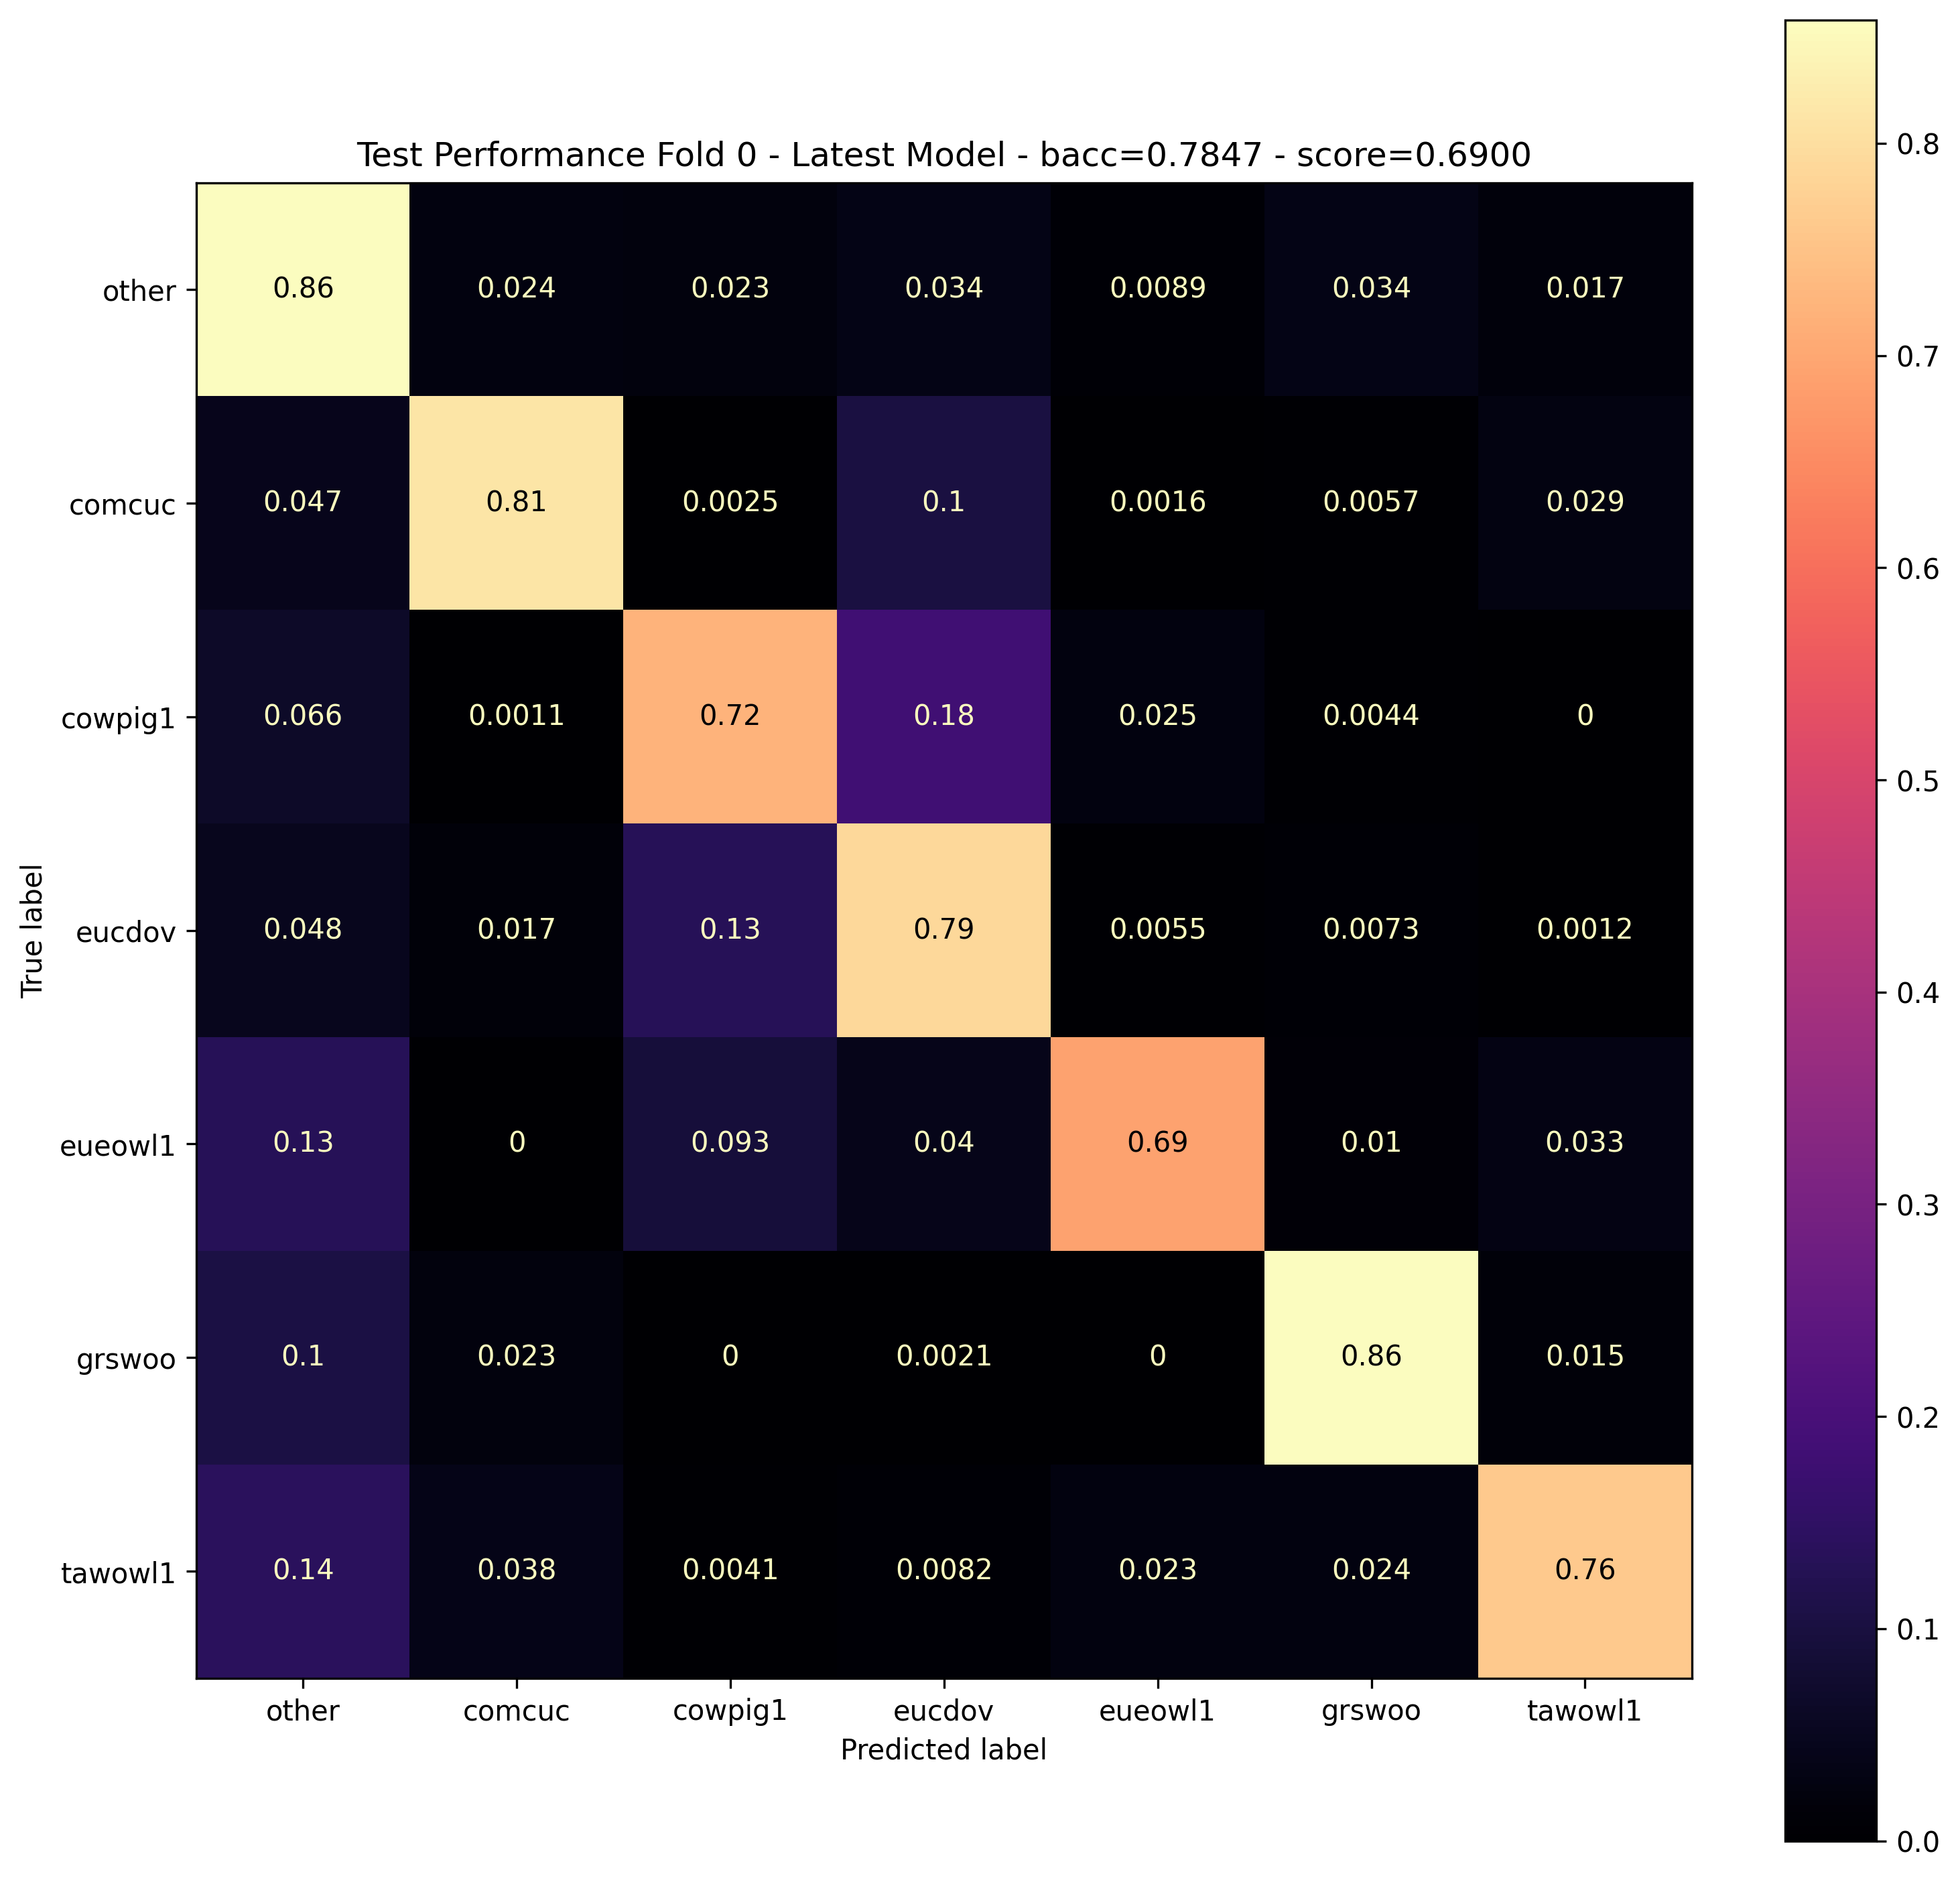

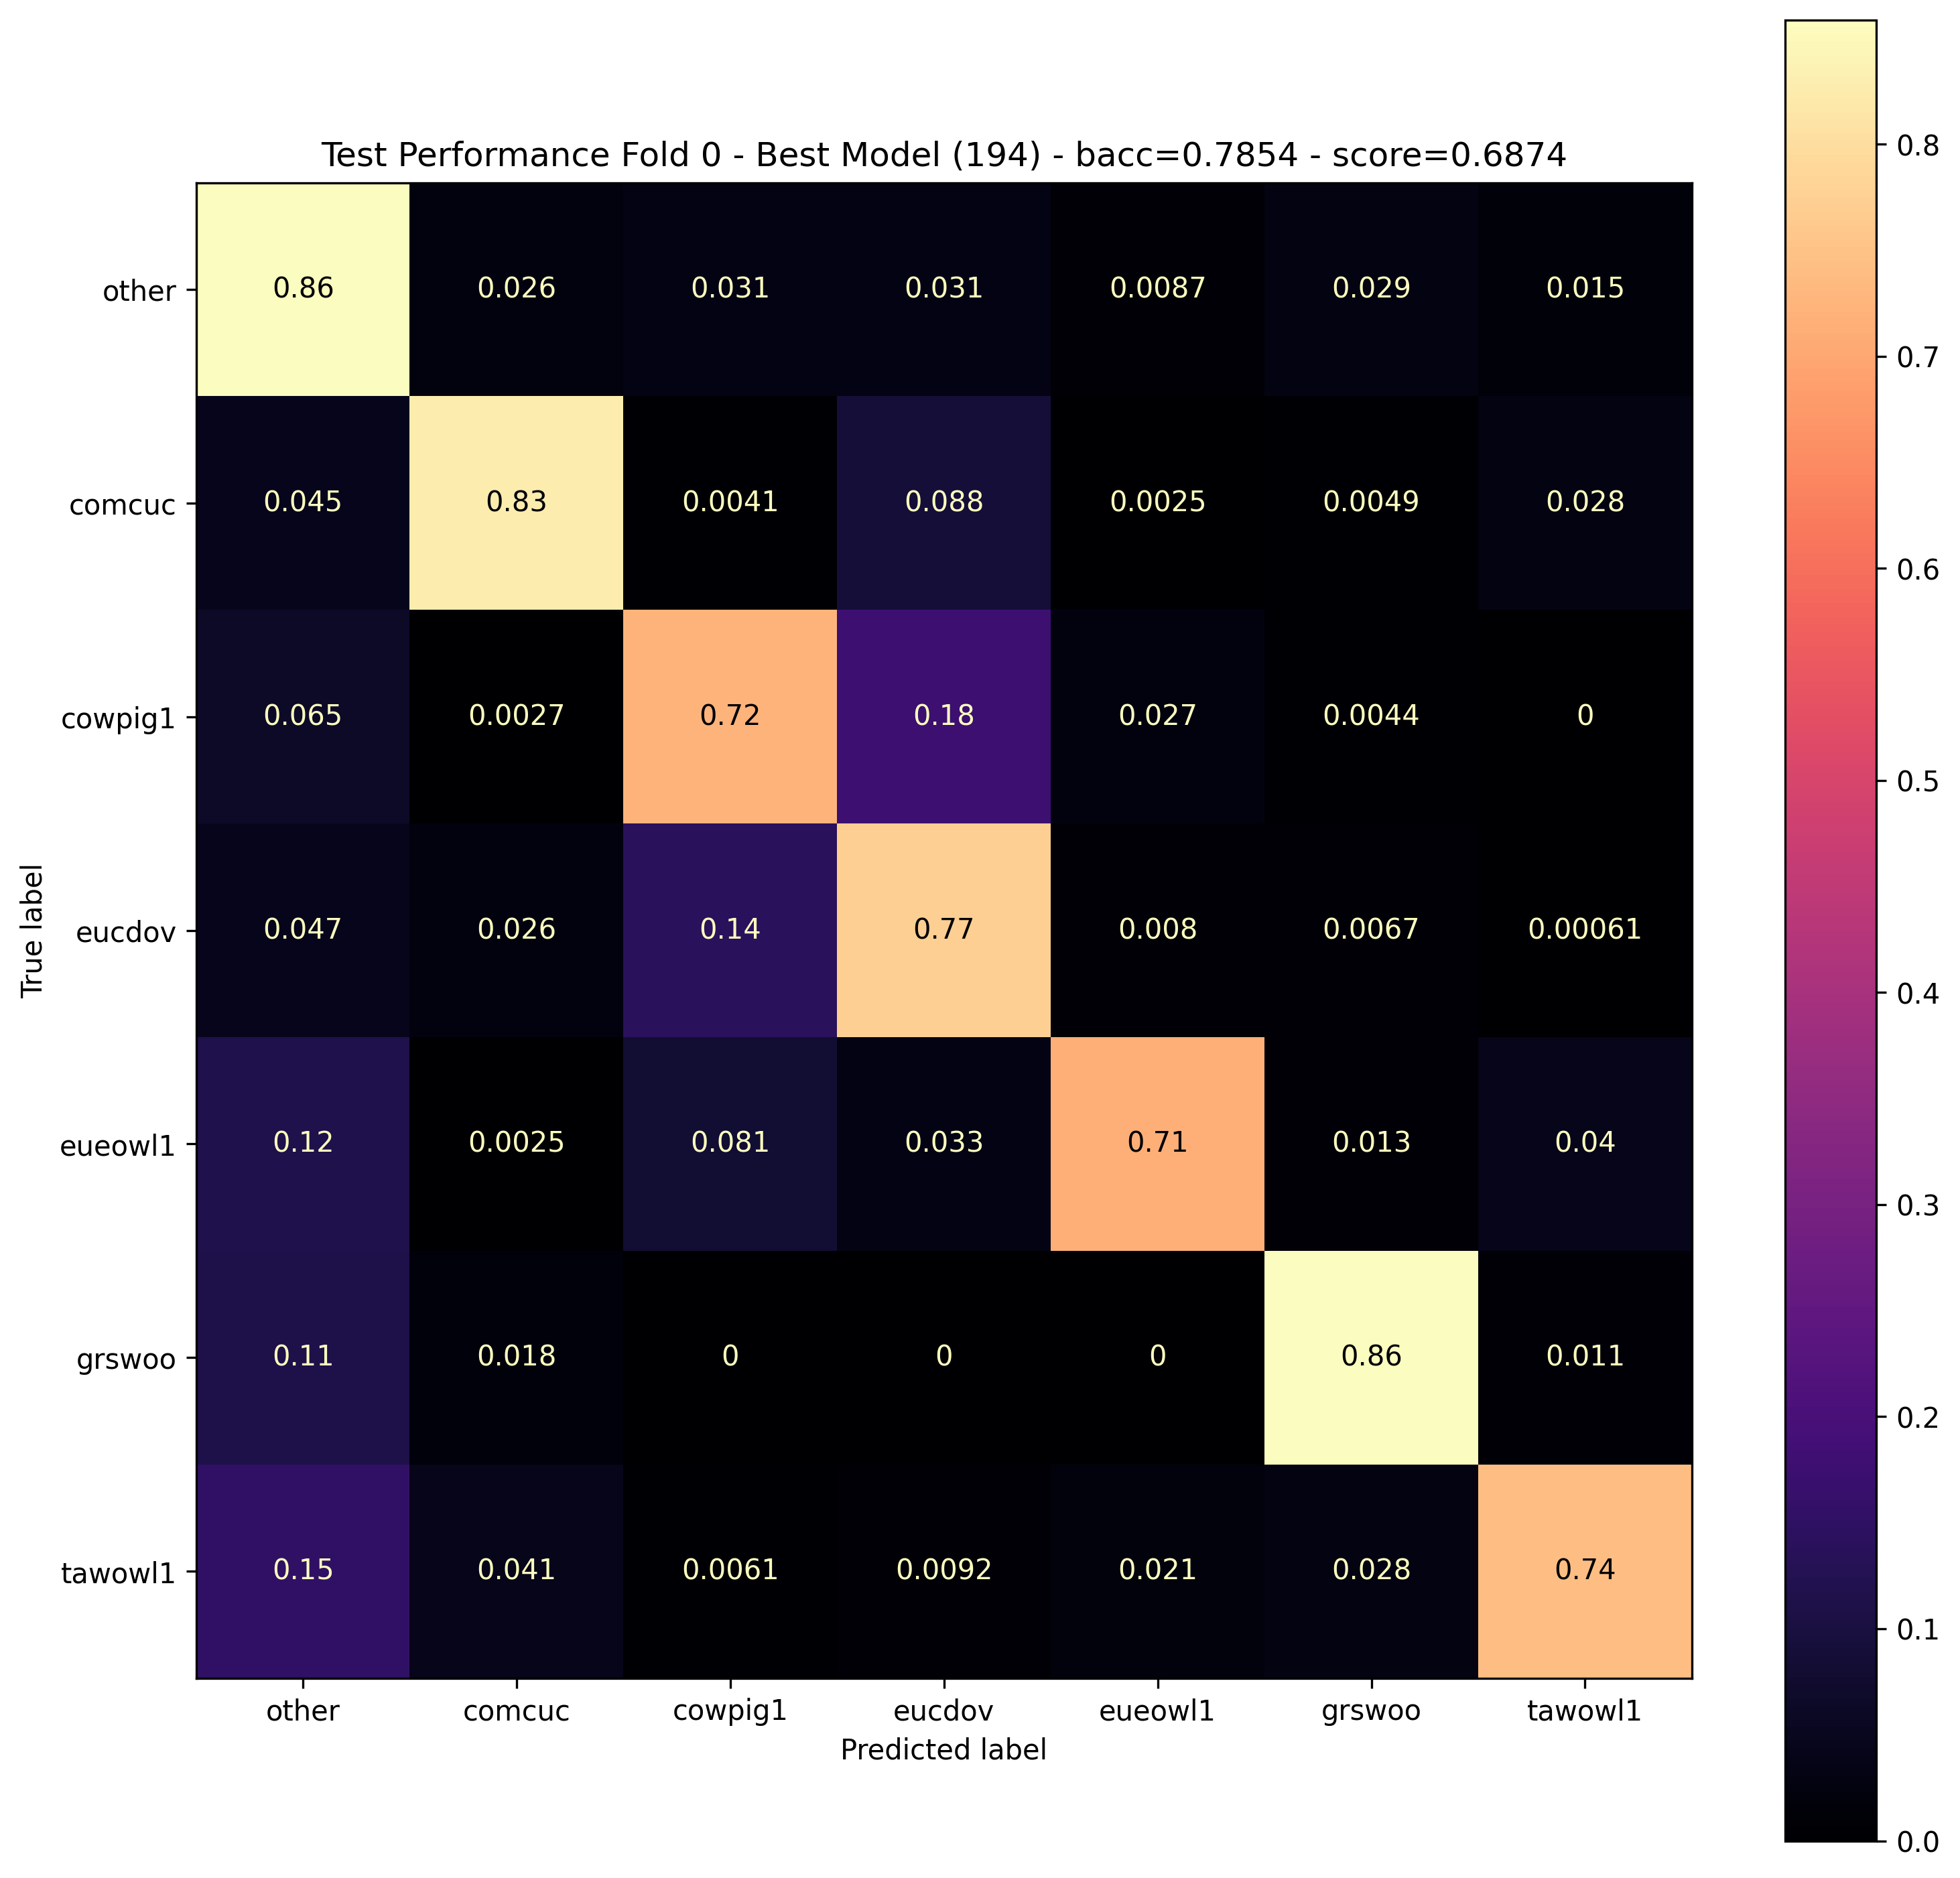

CV Folds:  12%|█████████████████████                                                                                                                                                   | 1/8 [00:46<05:28, 46.98s/it]

Best Model Test Metrics: avg_loss = 0.000116, num_samples = 24000, num_correct = 20011, acc = 0.833792, bacc = 0.785428, score = 0.687439
Saved model with scaler as "species_classifier cv2023-06-08_16.51 fold-0-best eval-score=0.8011 test-score=0.6874 "



Executing CV for fold 1
Training fold 1


#### Training ####
##################
AttentionClassifier with 57819 parameters, in_fnn: 41196, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [59798,  4044,  6294,  5662,  1647,  3614,  2941]
train label counts = [ 8568,   570,   831,   902,   281,   547,   301]

loss weights                    = [ 0.74, 14.79,  6.33, 10.56, 36.31, 16.55, 20.33]
eval loss weights (theoretical) = [ 0.74, 15.03,  6.87,  9.50, 30.49, 15.66, 28.47]


Training Epoch   1/200: lr = 1.00E-03, epoch =     1, avg_loss = 0.000209, num_samples = 84000, num_correct =  3920, acc = 0.046667, bacc = 0.141288, score = -0.382070
Evaluation Epoch   1/200: epoch =     1, avg_loss = 0.000353, num_

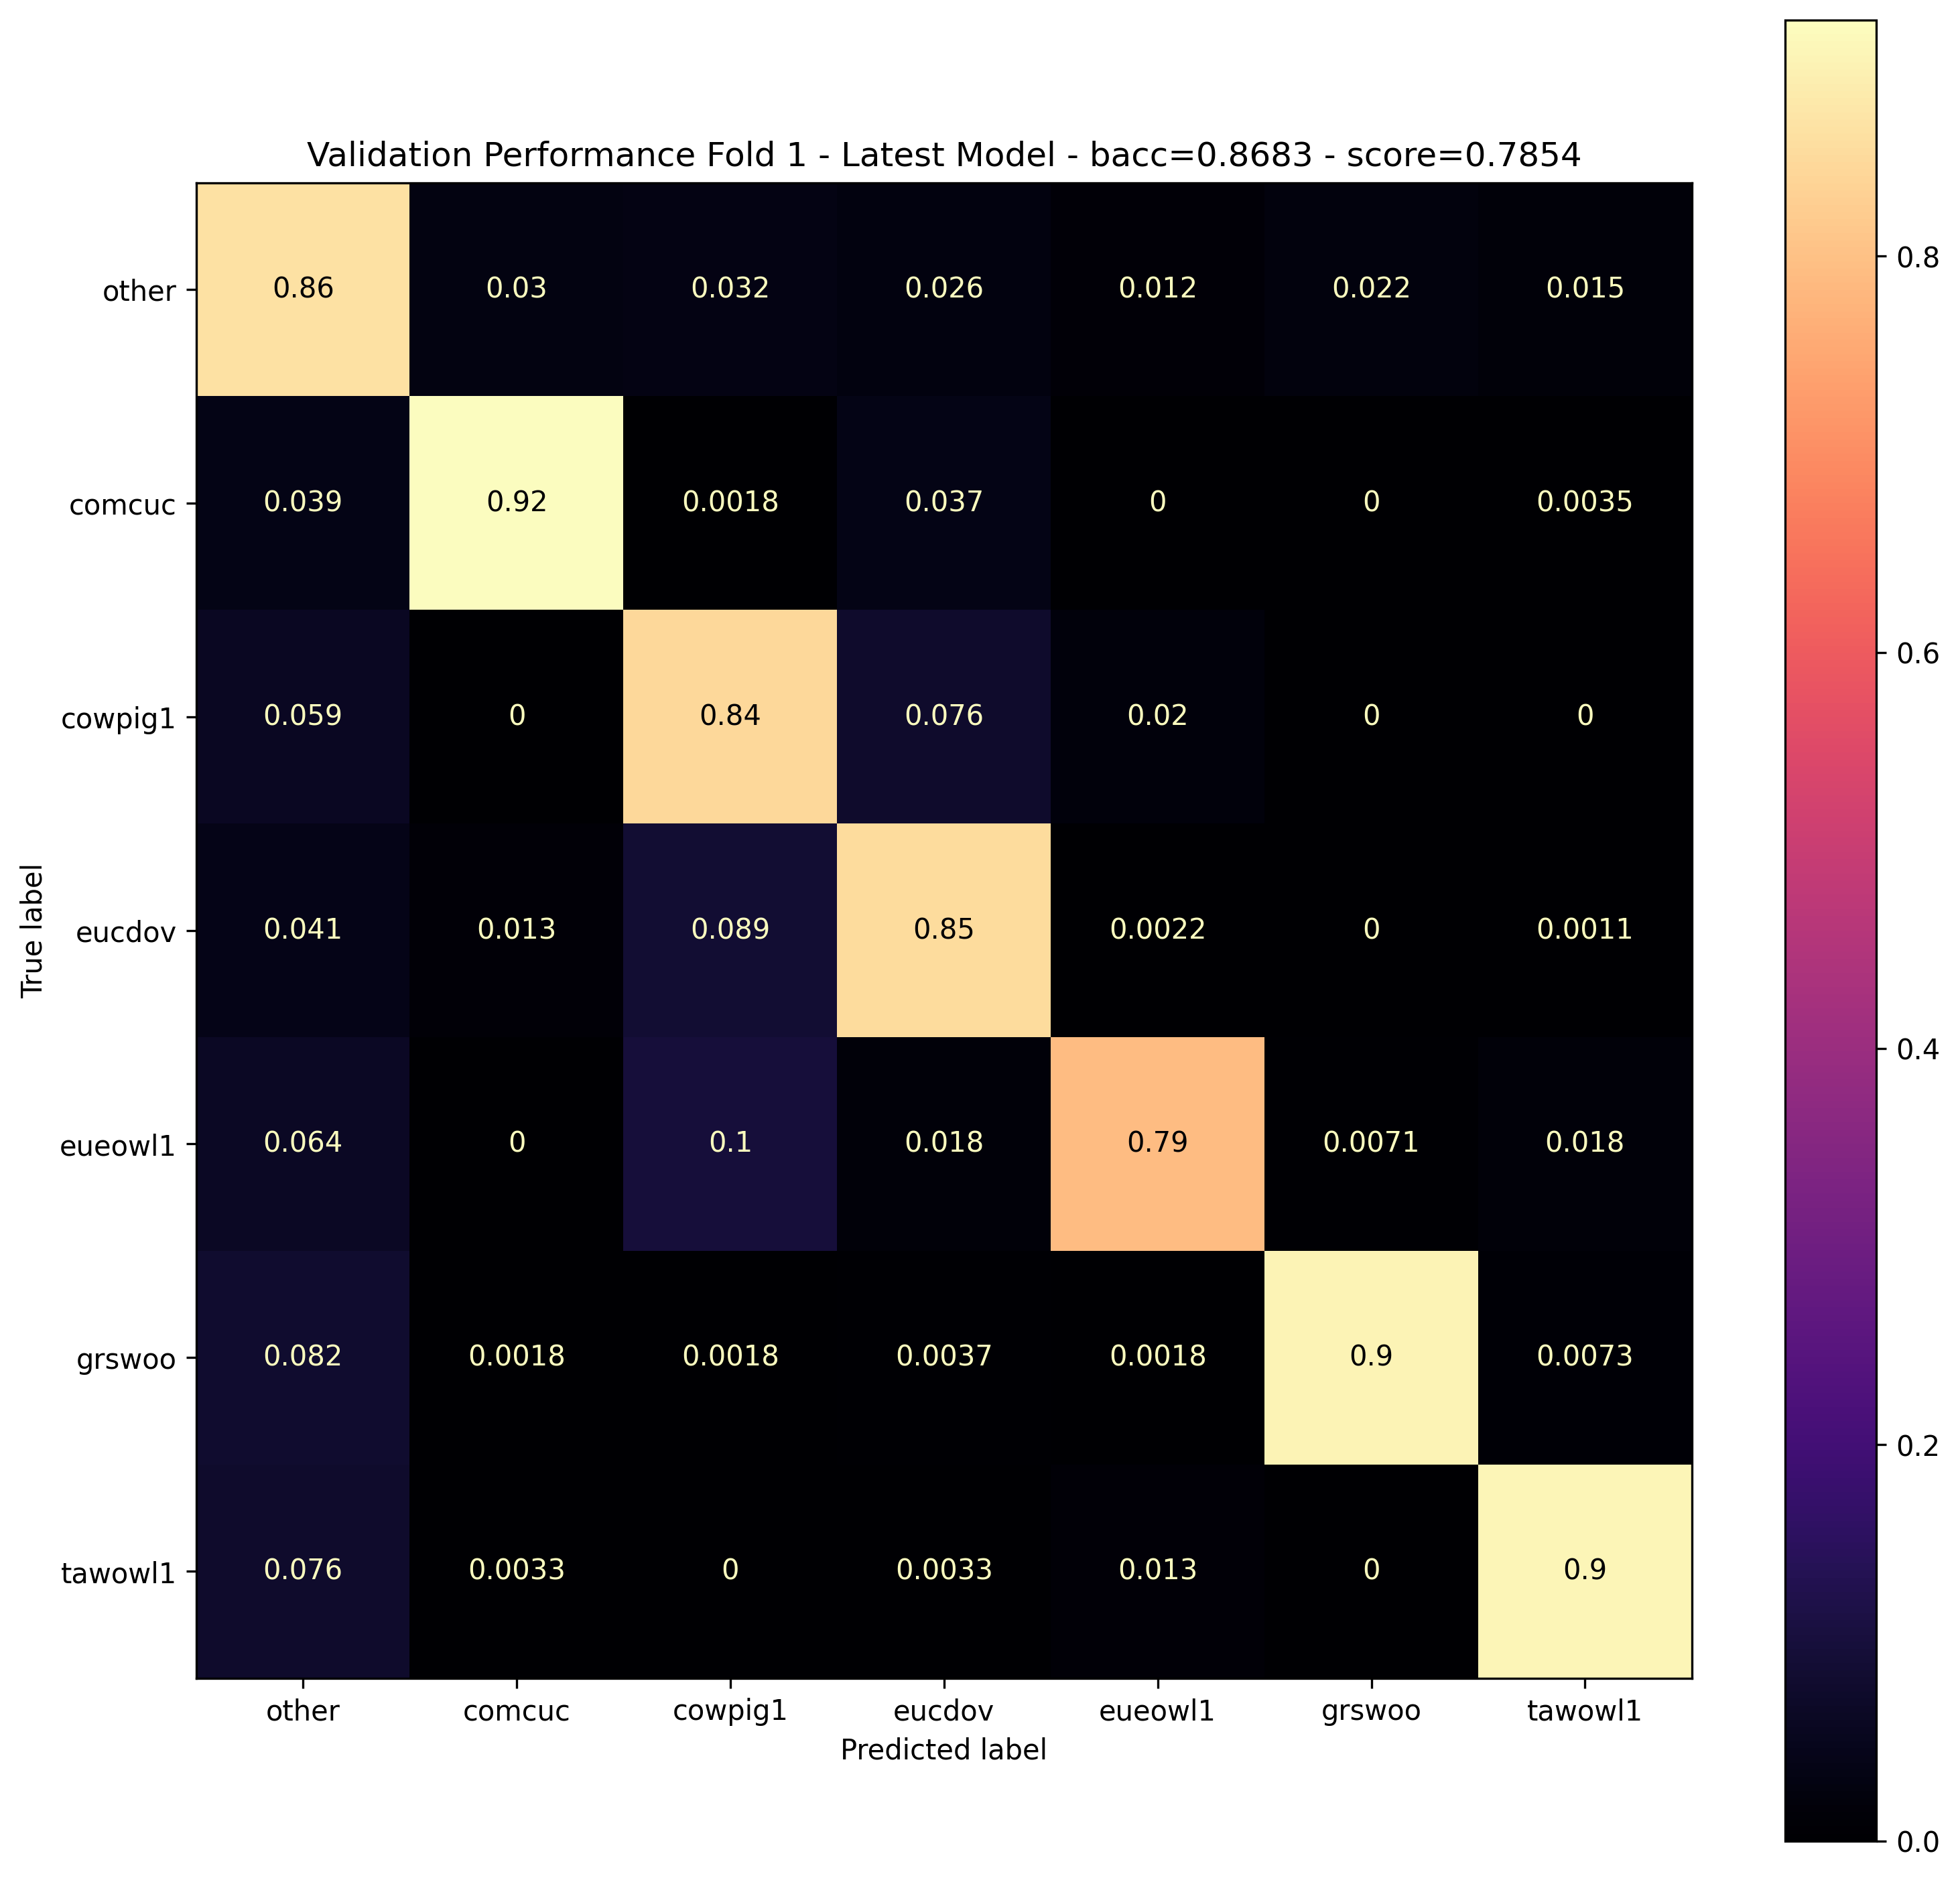

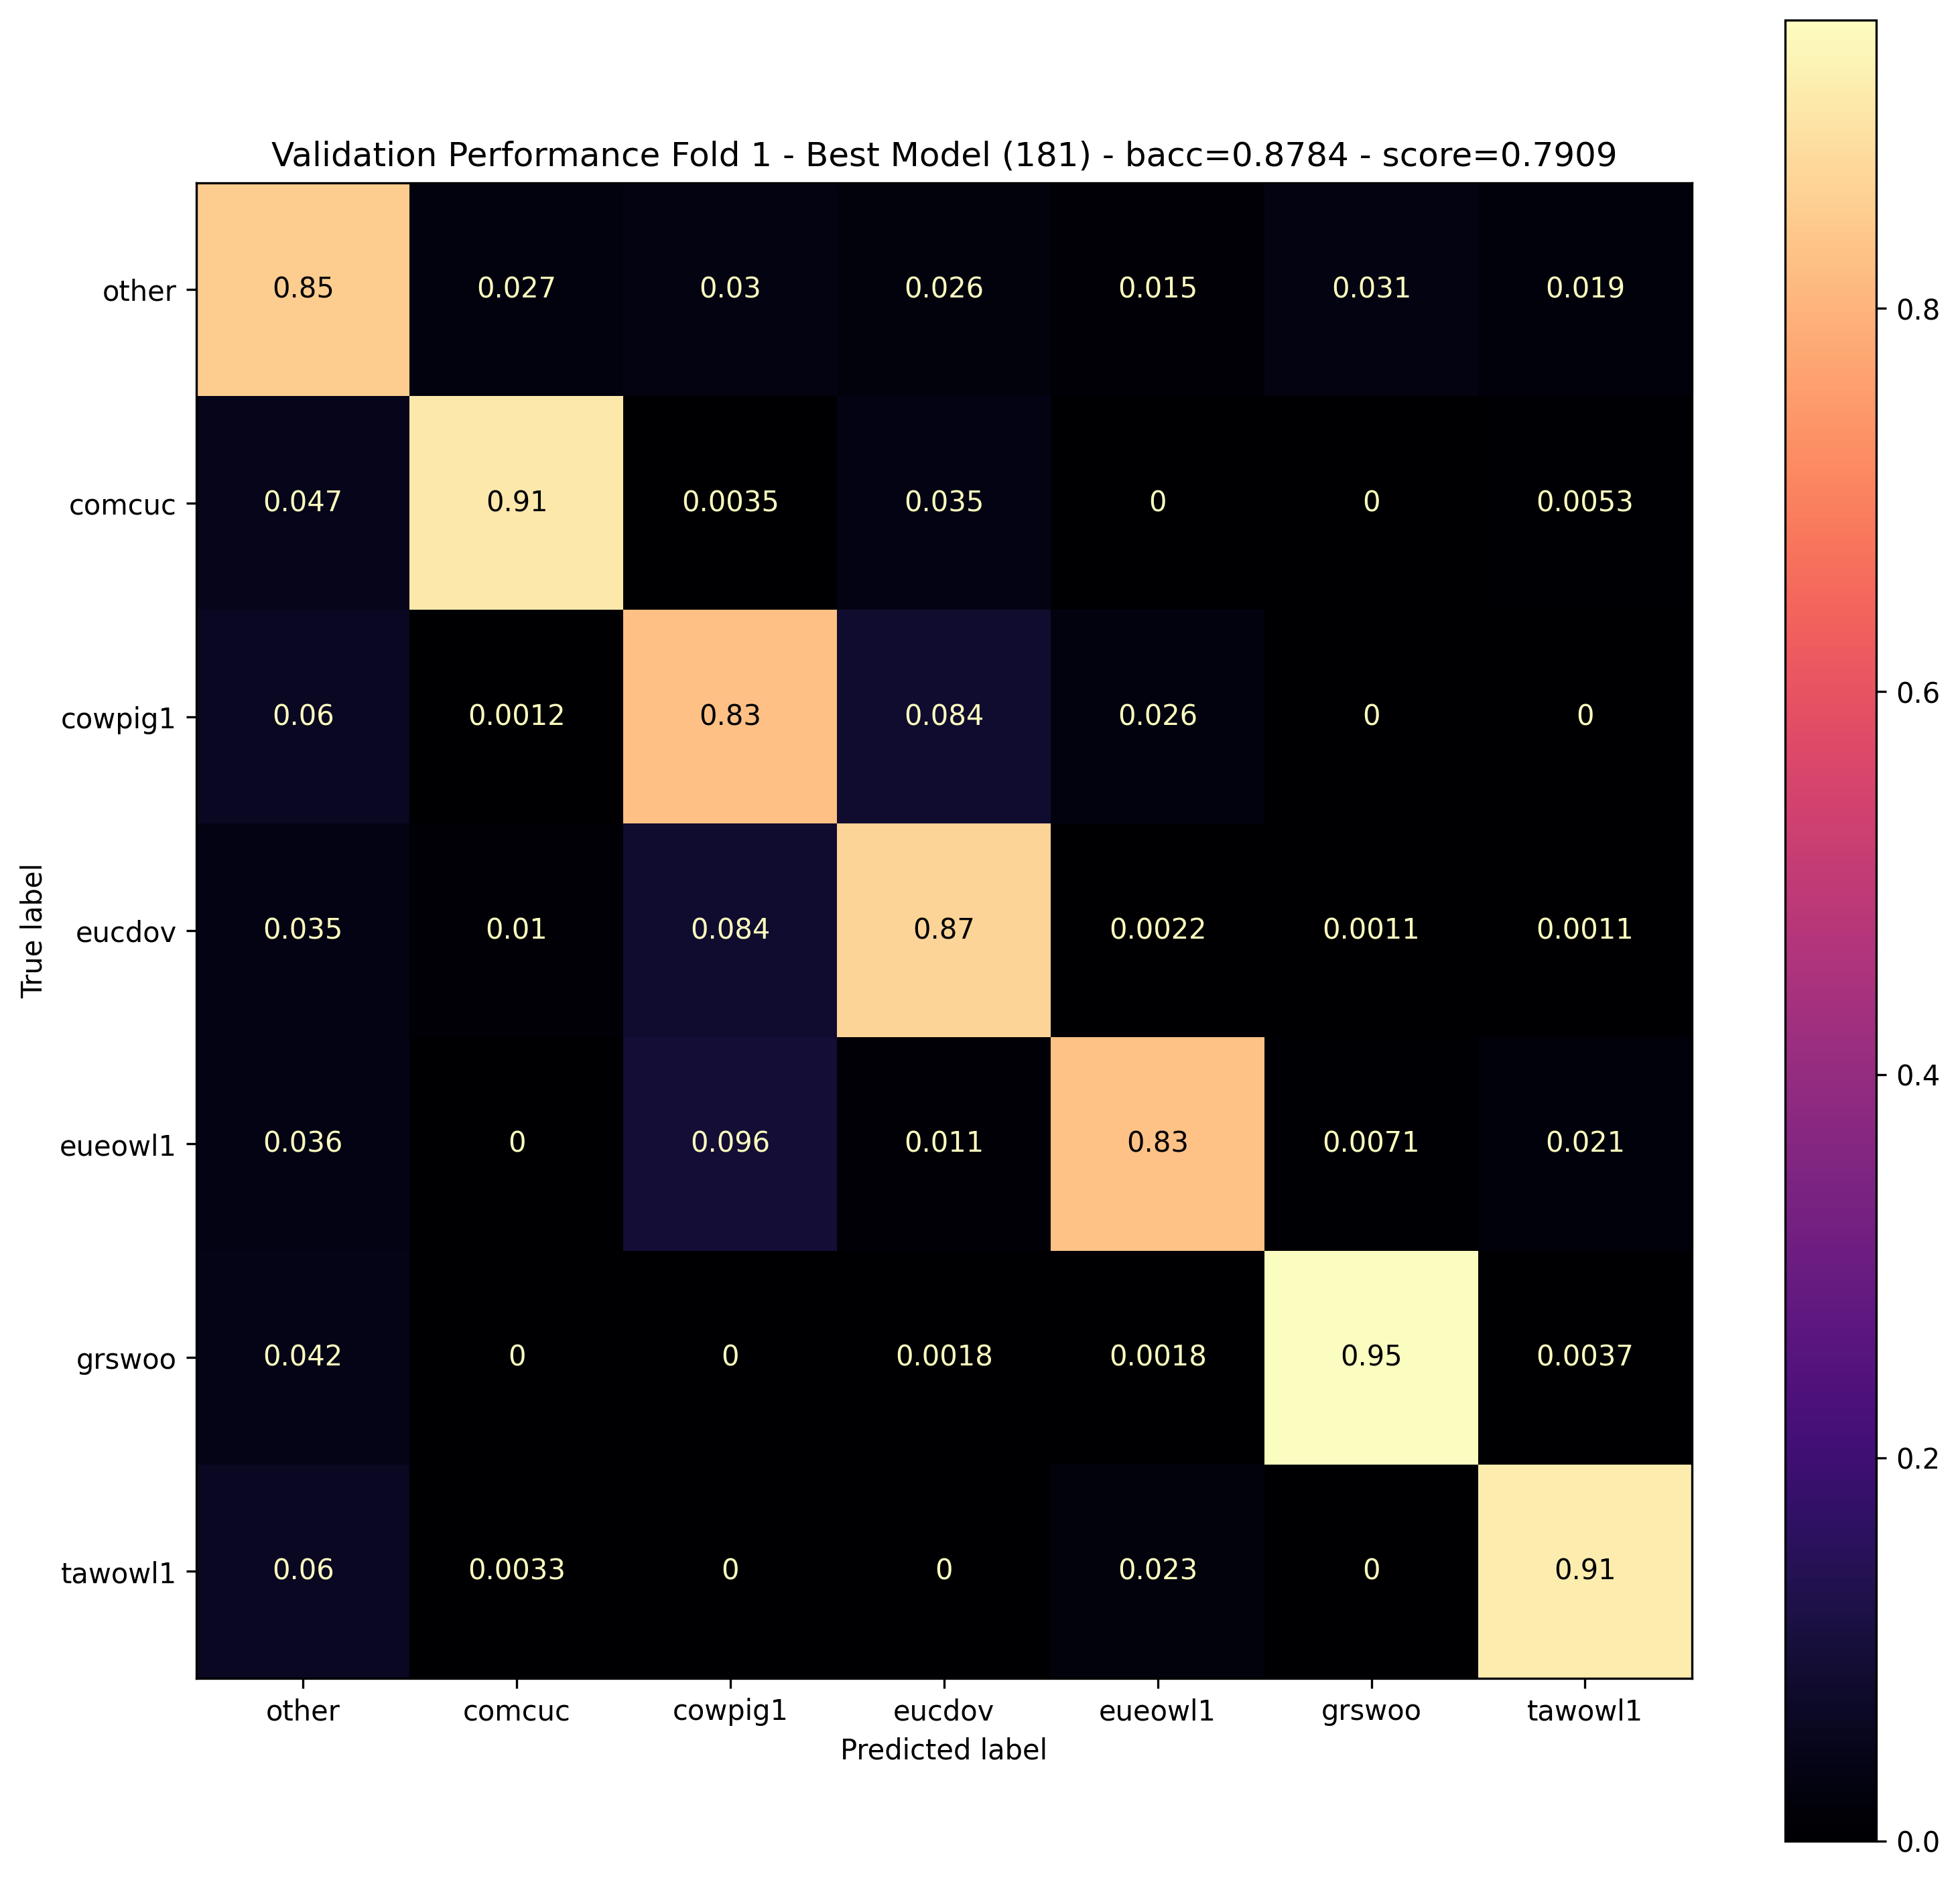


Testing fold 1


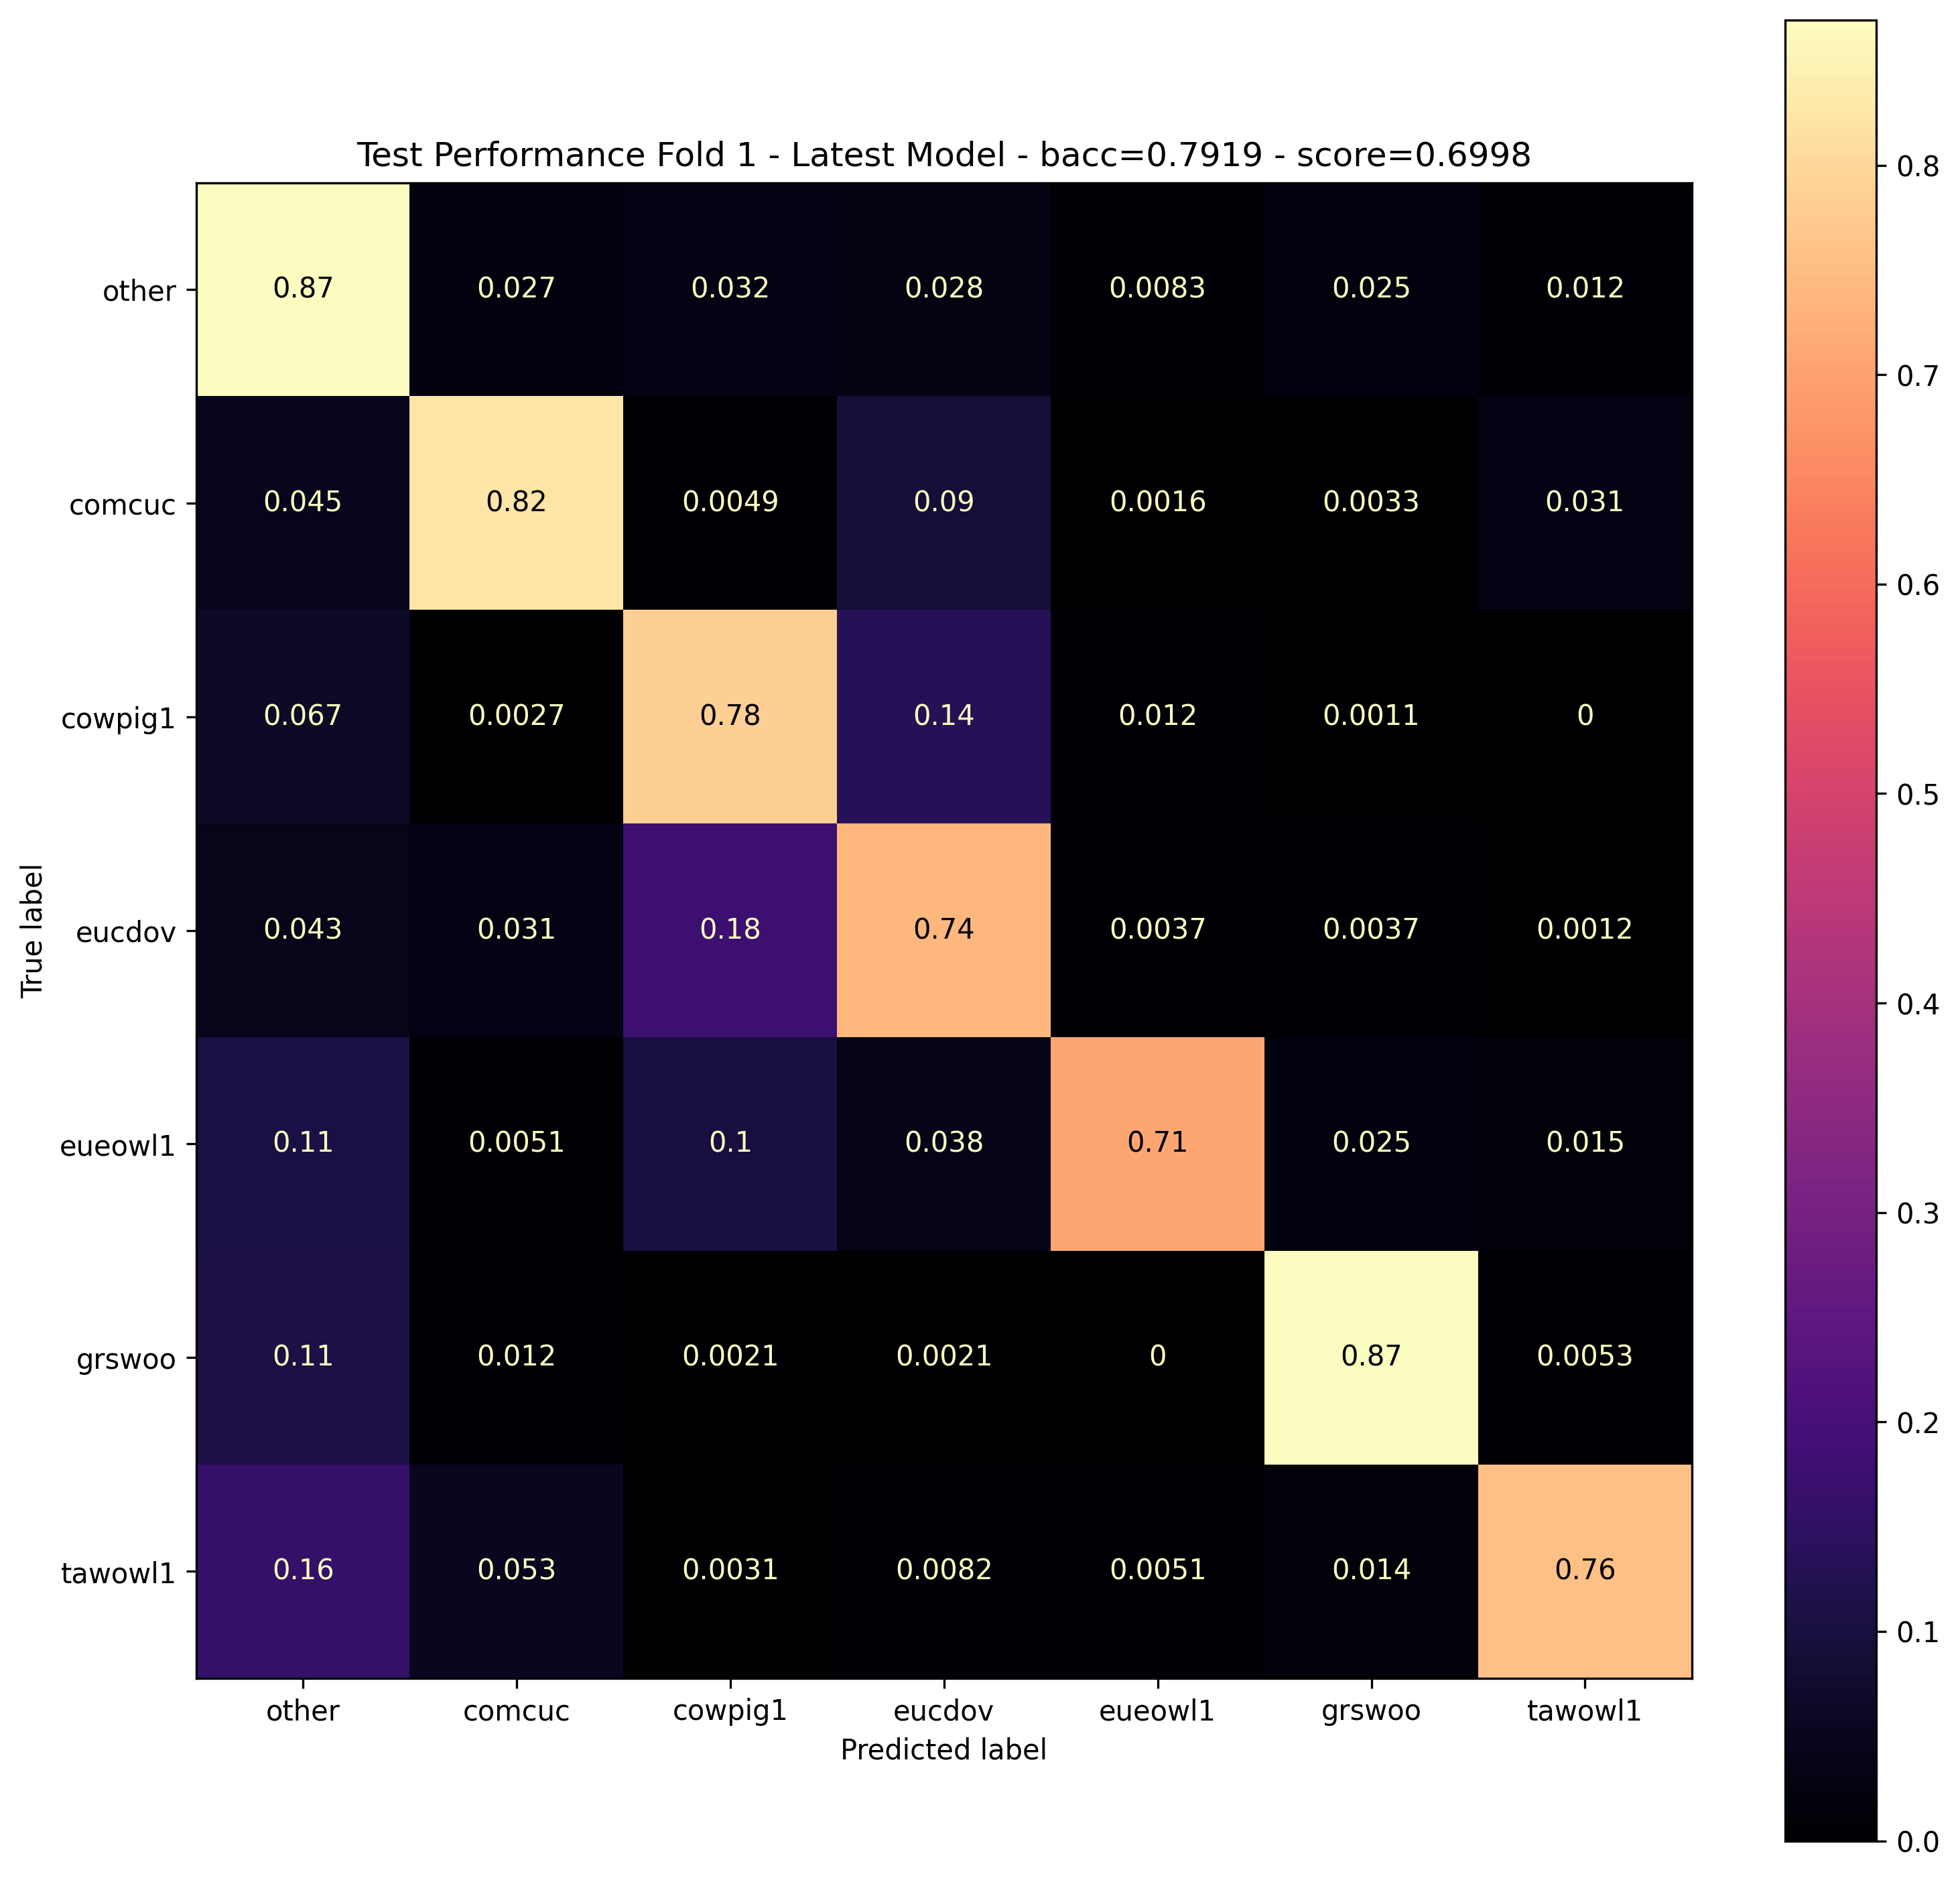

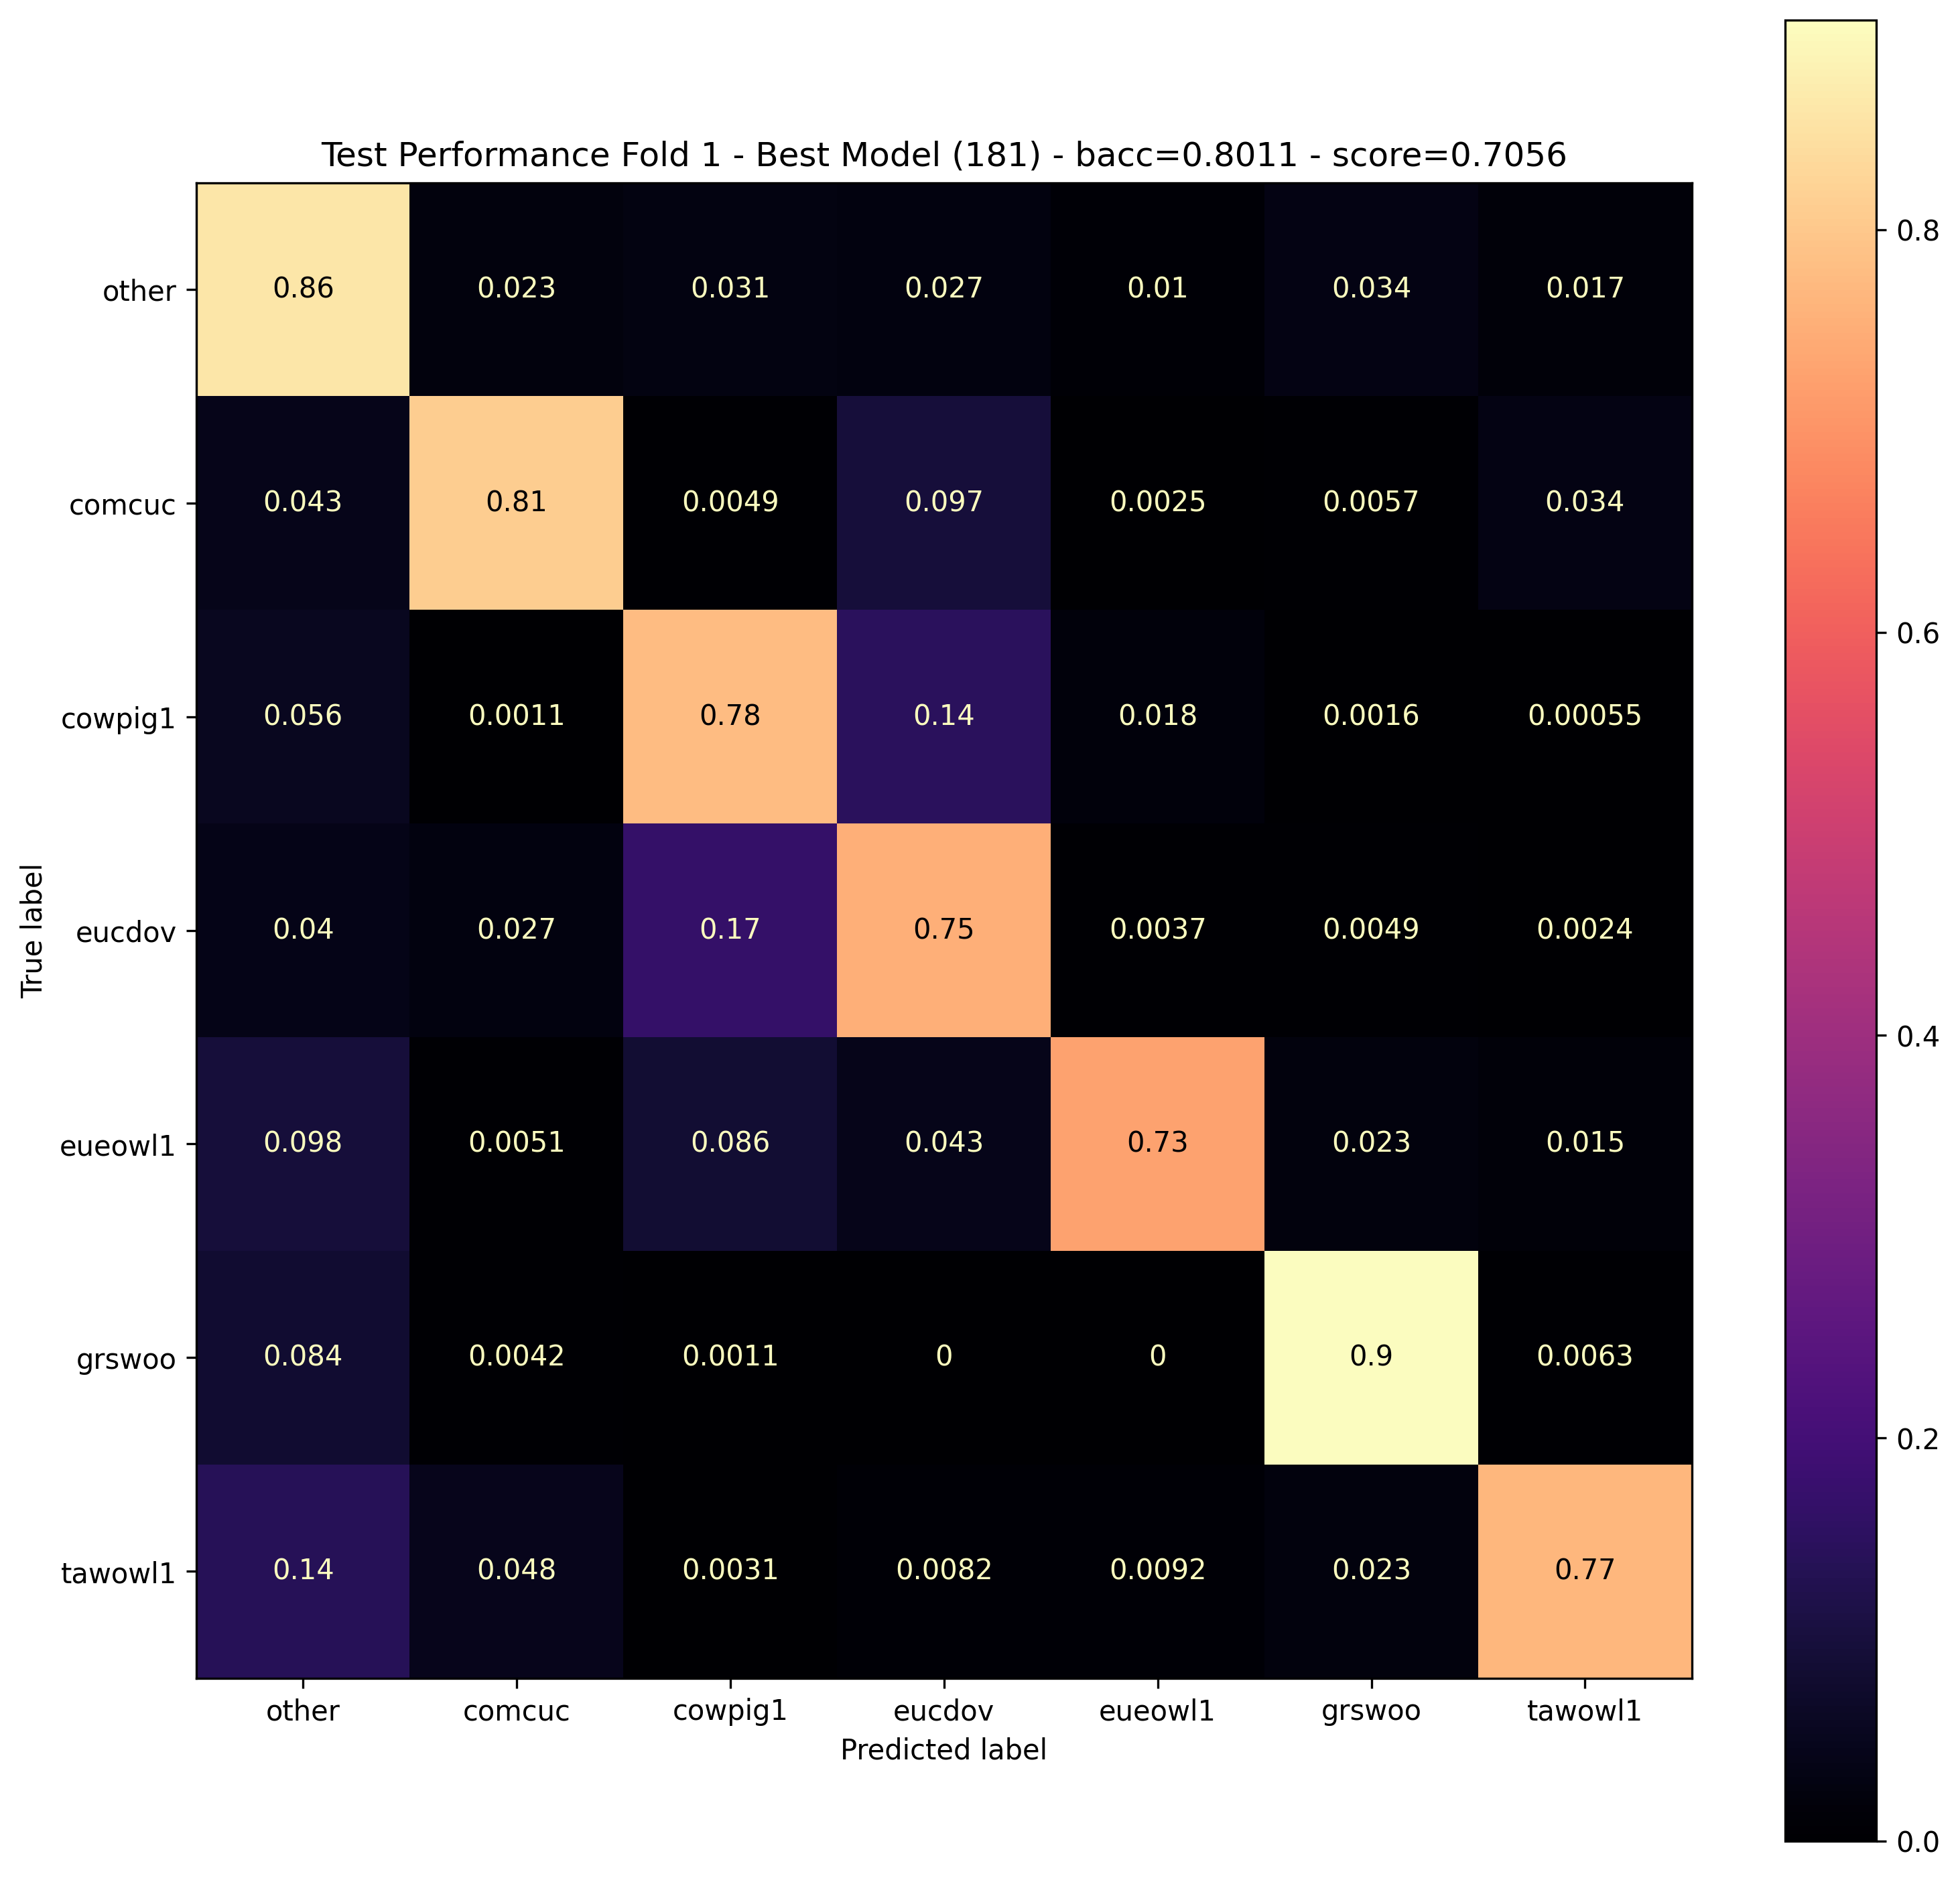

CV Folds:  25%|██████████████████████████████████████████                                                                                                                              | 2/8 [01:32<04:35, 45.96s/it]

Best Model Test Metrics: avg_loss = 0.000101, num_samples = 24000, num_correct = 20157, acc = 0.839875, bacc = 0.801129, score = 0.705617
Saved model with scaler as "species_classifier cv2023-06-08_16.51 fold-1-best eval-score=0.7909 test-score=0.7056 "



Executing CV for fold 2
Training fold 2


#### Training ####
##################
AttentionClassifier with 57819 parameters, in_fnn: 41196, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [59817,  3913,  6253,  5976,  1697,  3431,  2913]
train label counts = [ 8549,   701,   872,   588,   231,   730,   329]

loss weights                    = [ 0.74, 15.29,  6.38, 10.01, 35.25, 17.43, 20.53]
eval loss weights (theoretical) = [ 0.74, 12.20,  6.54, 14.54, 37.01, 11.71, 25.98]


Training Epoch   1/200: lr = 1.00E-03, epoch =     1, avg_loss = 0.000210, num_samples = 84000, num_correct = 36798, acc = 0.438071, bacc = 0.140371, score = -0.196166
Evaluation Epoch   1/200: epoch =     1, avg_loss = 0.000314, num_

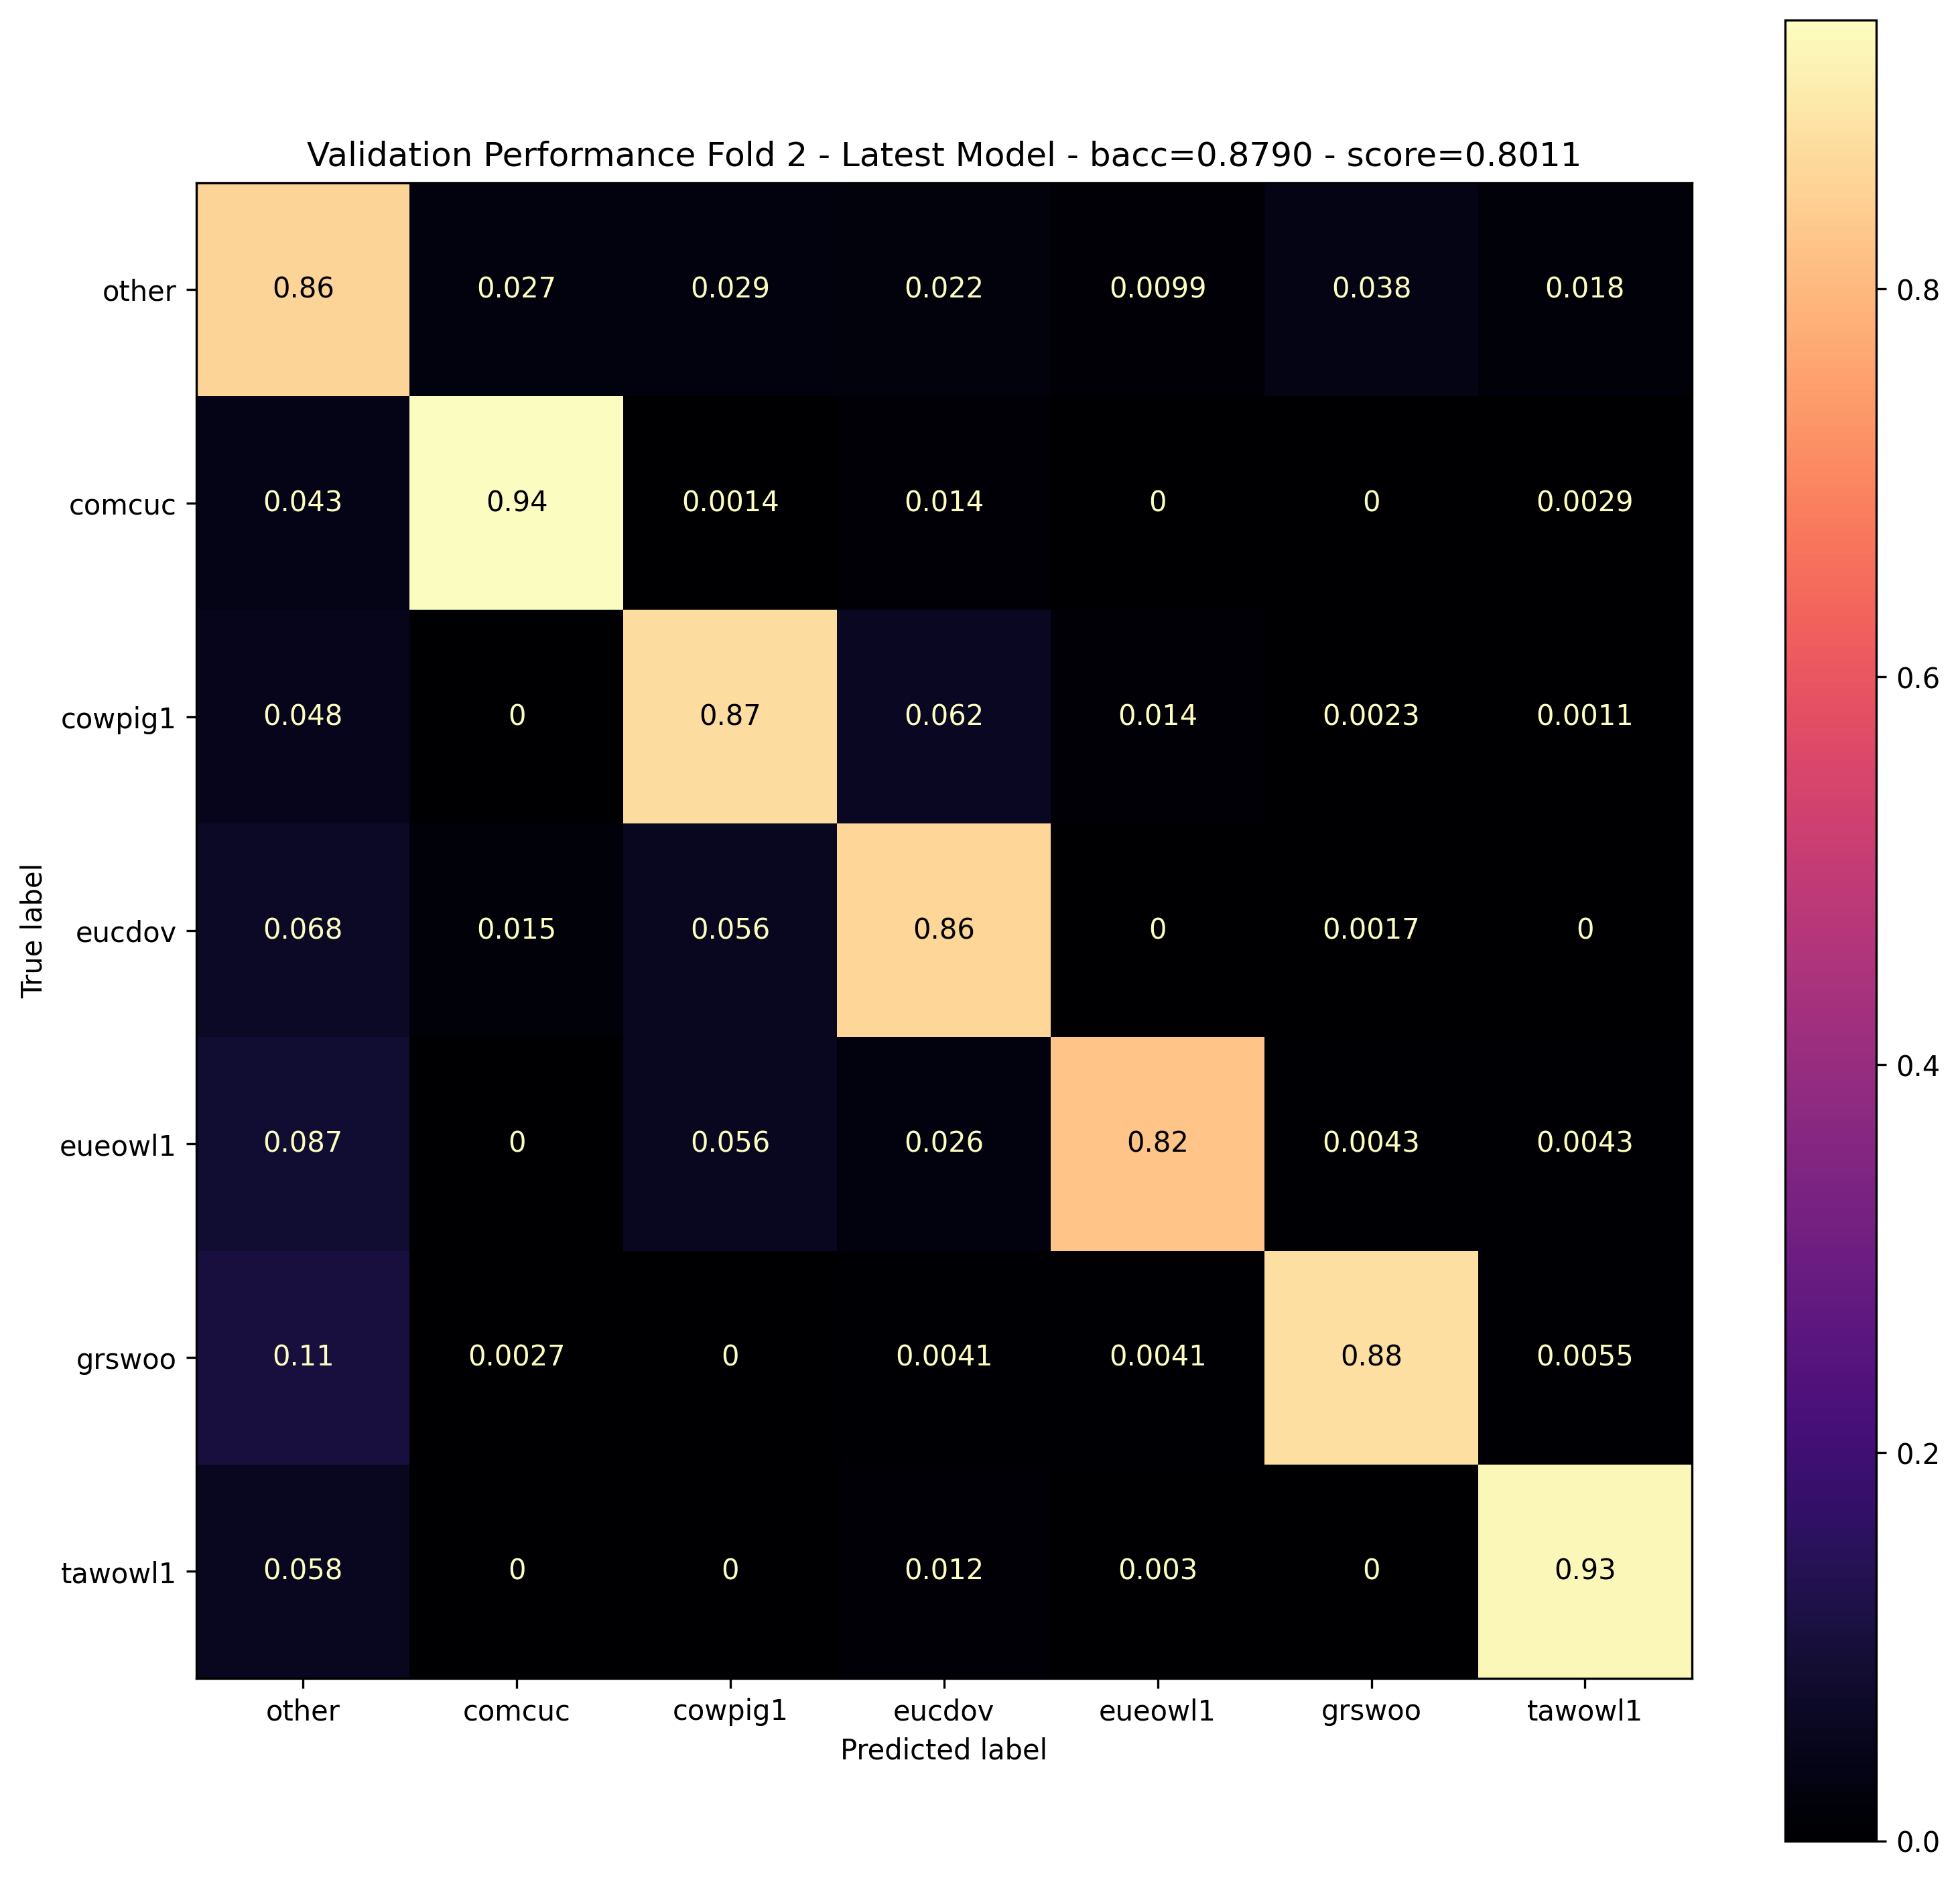

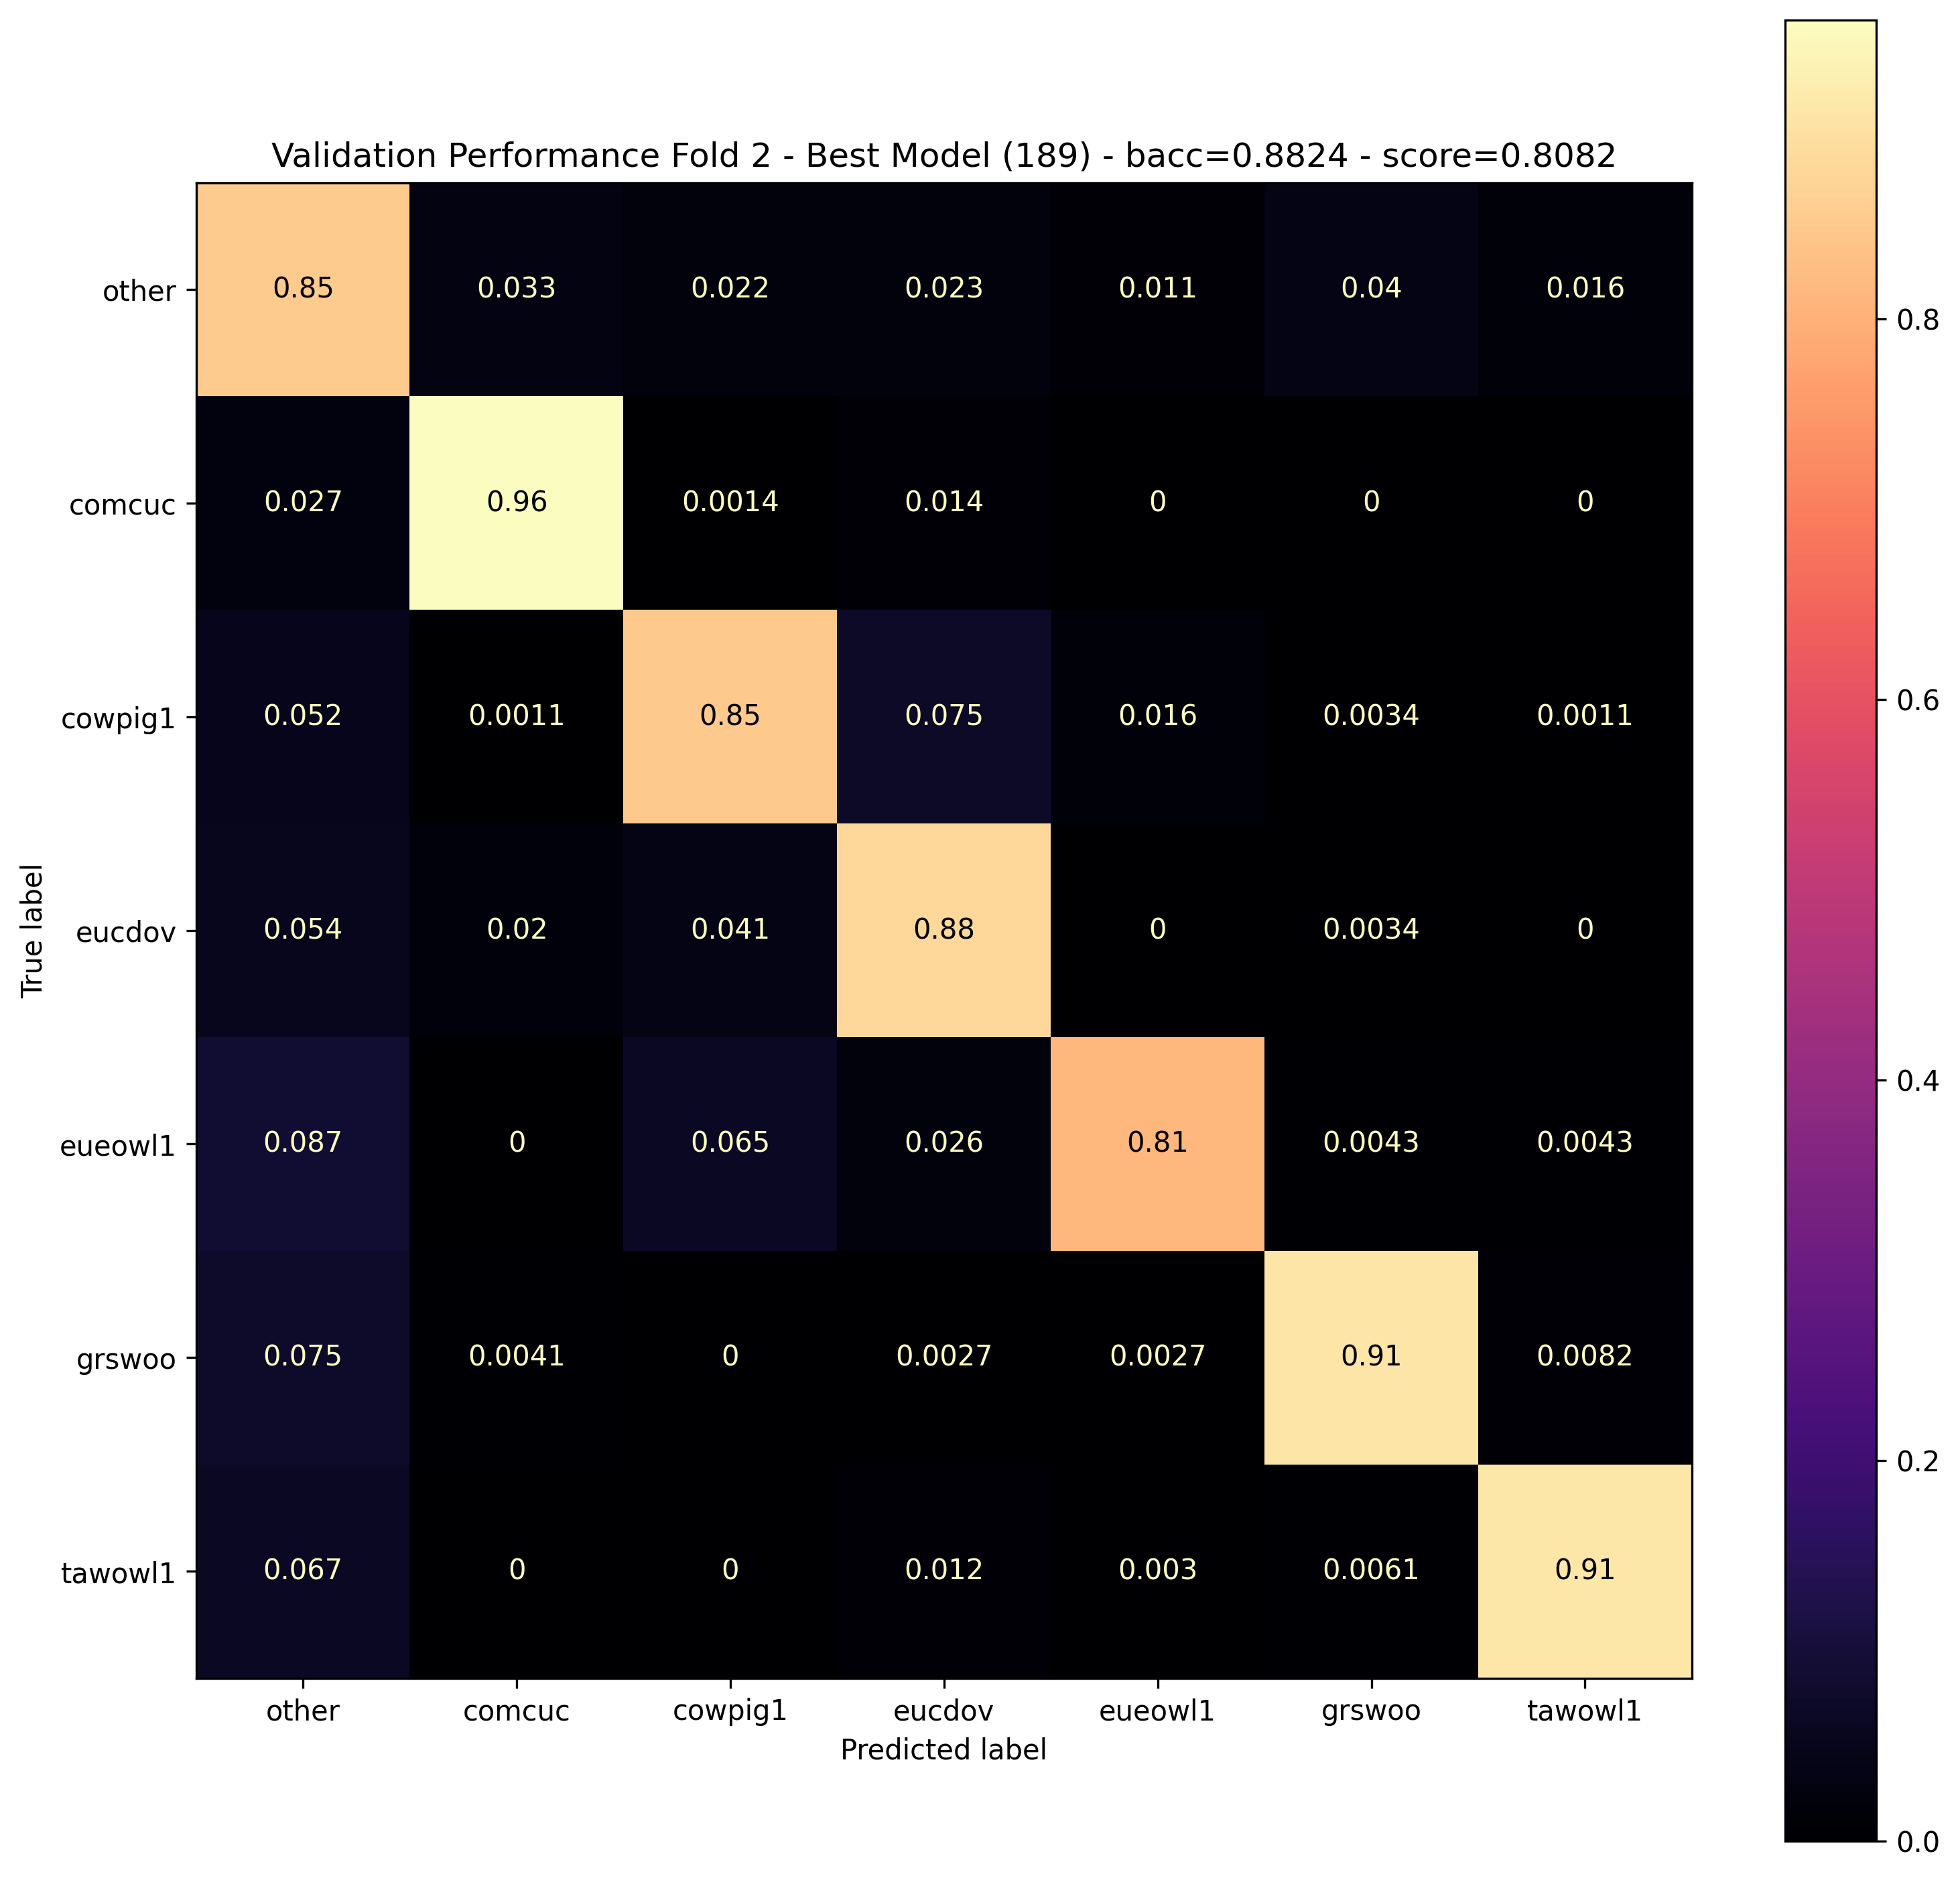


Testing fold 2


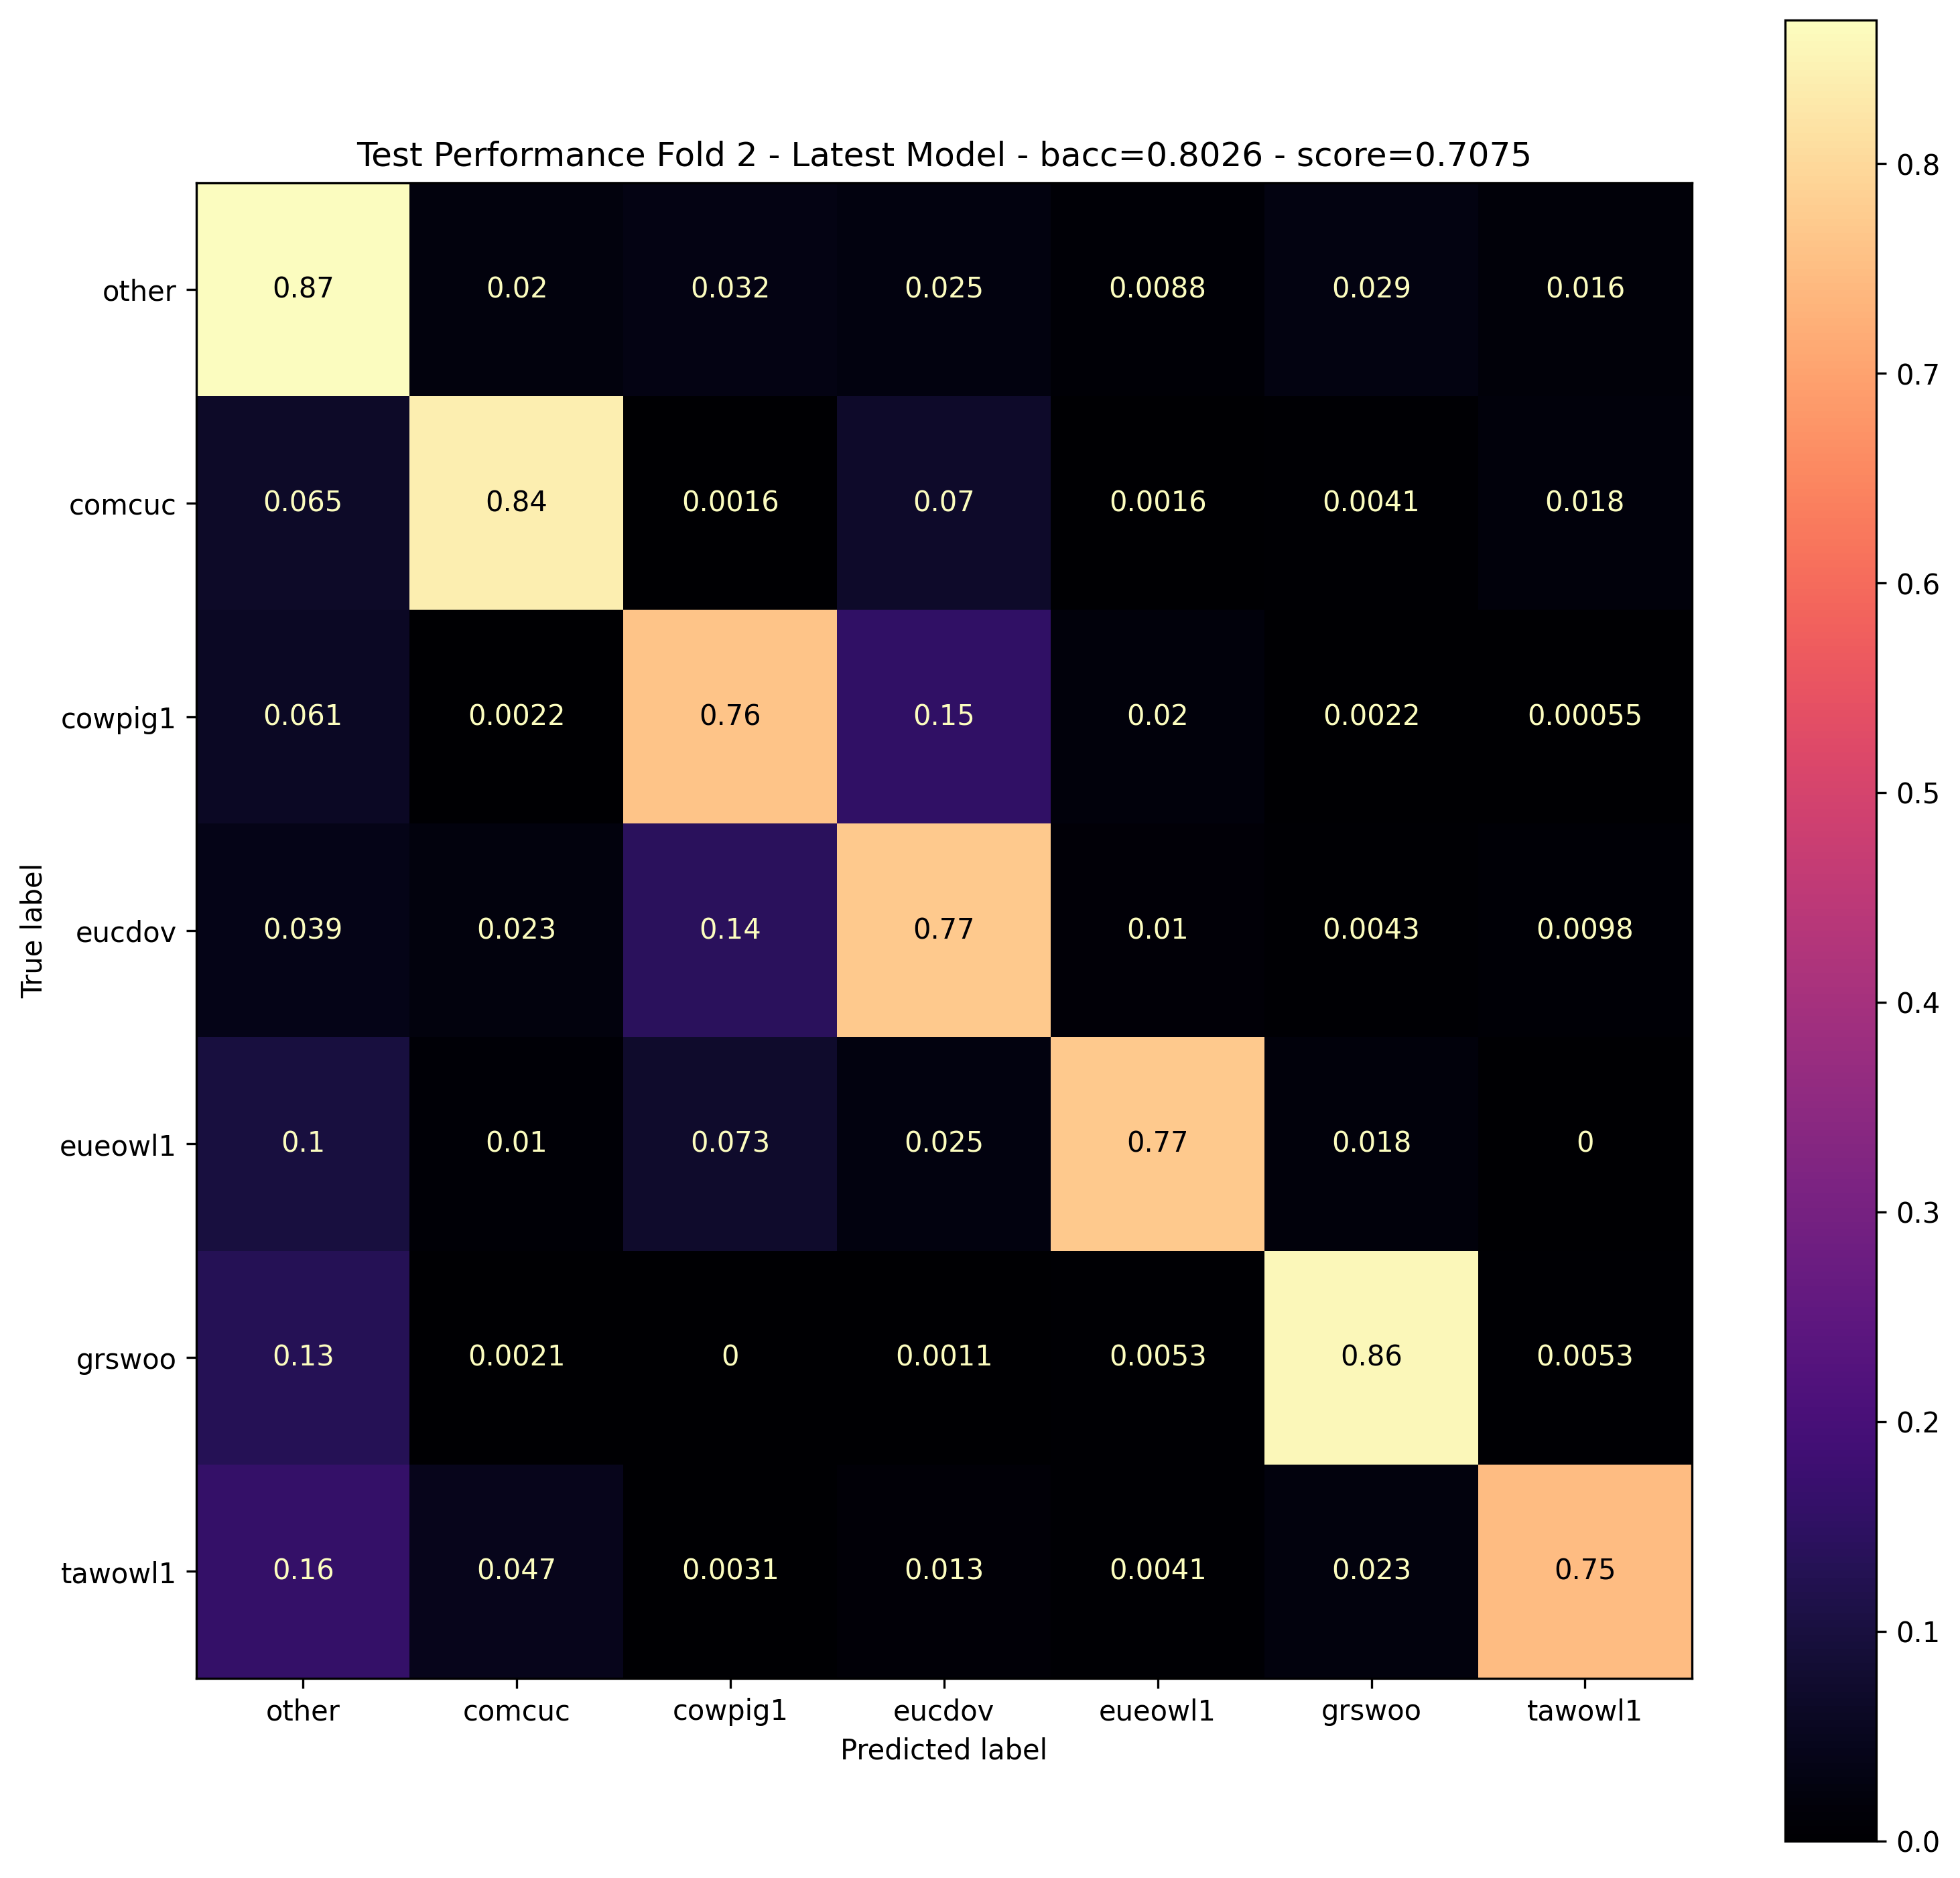

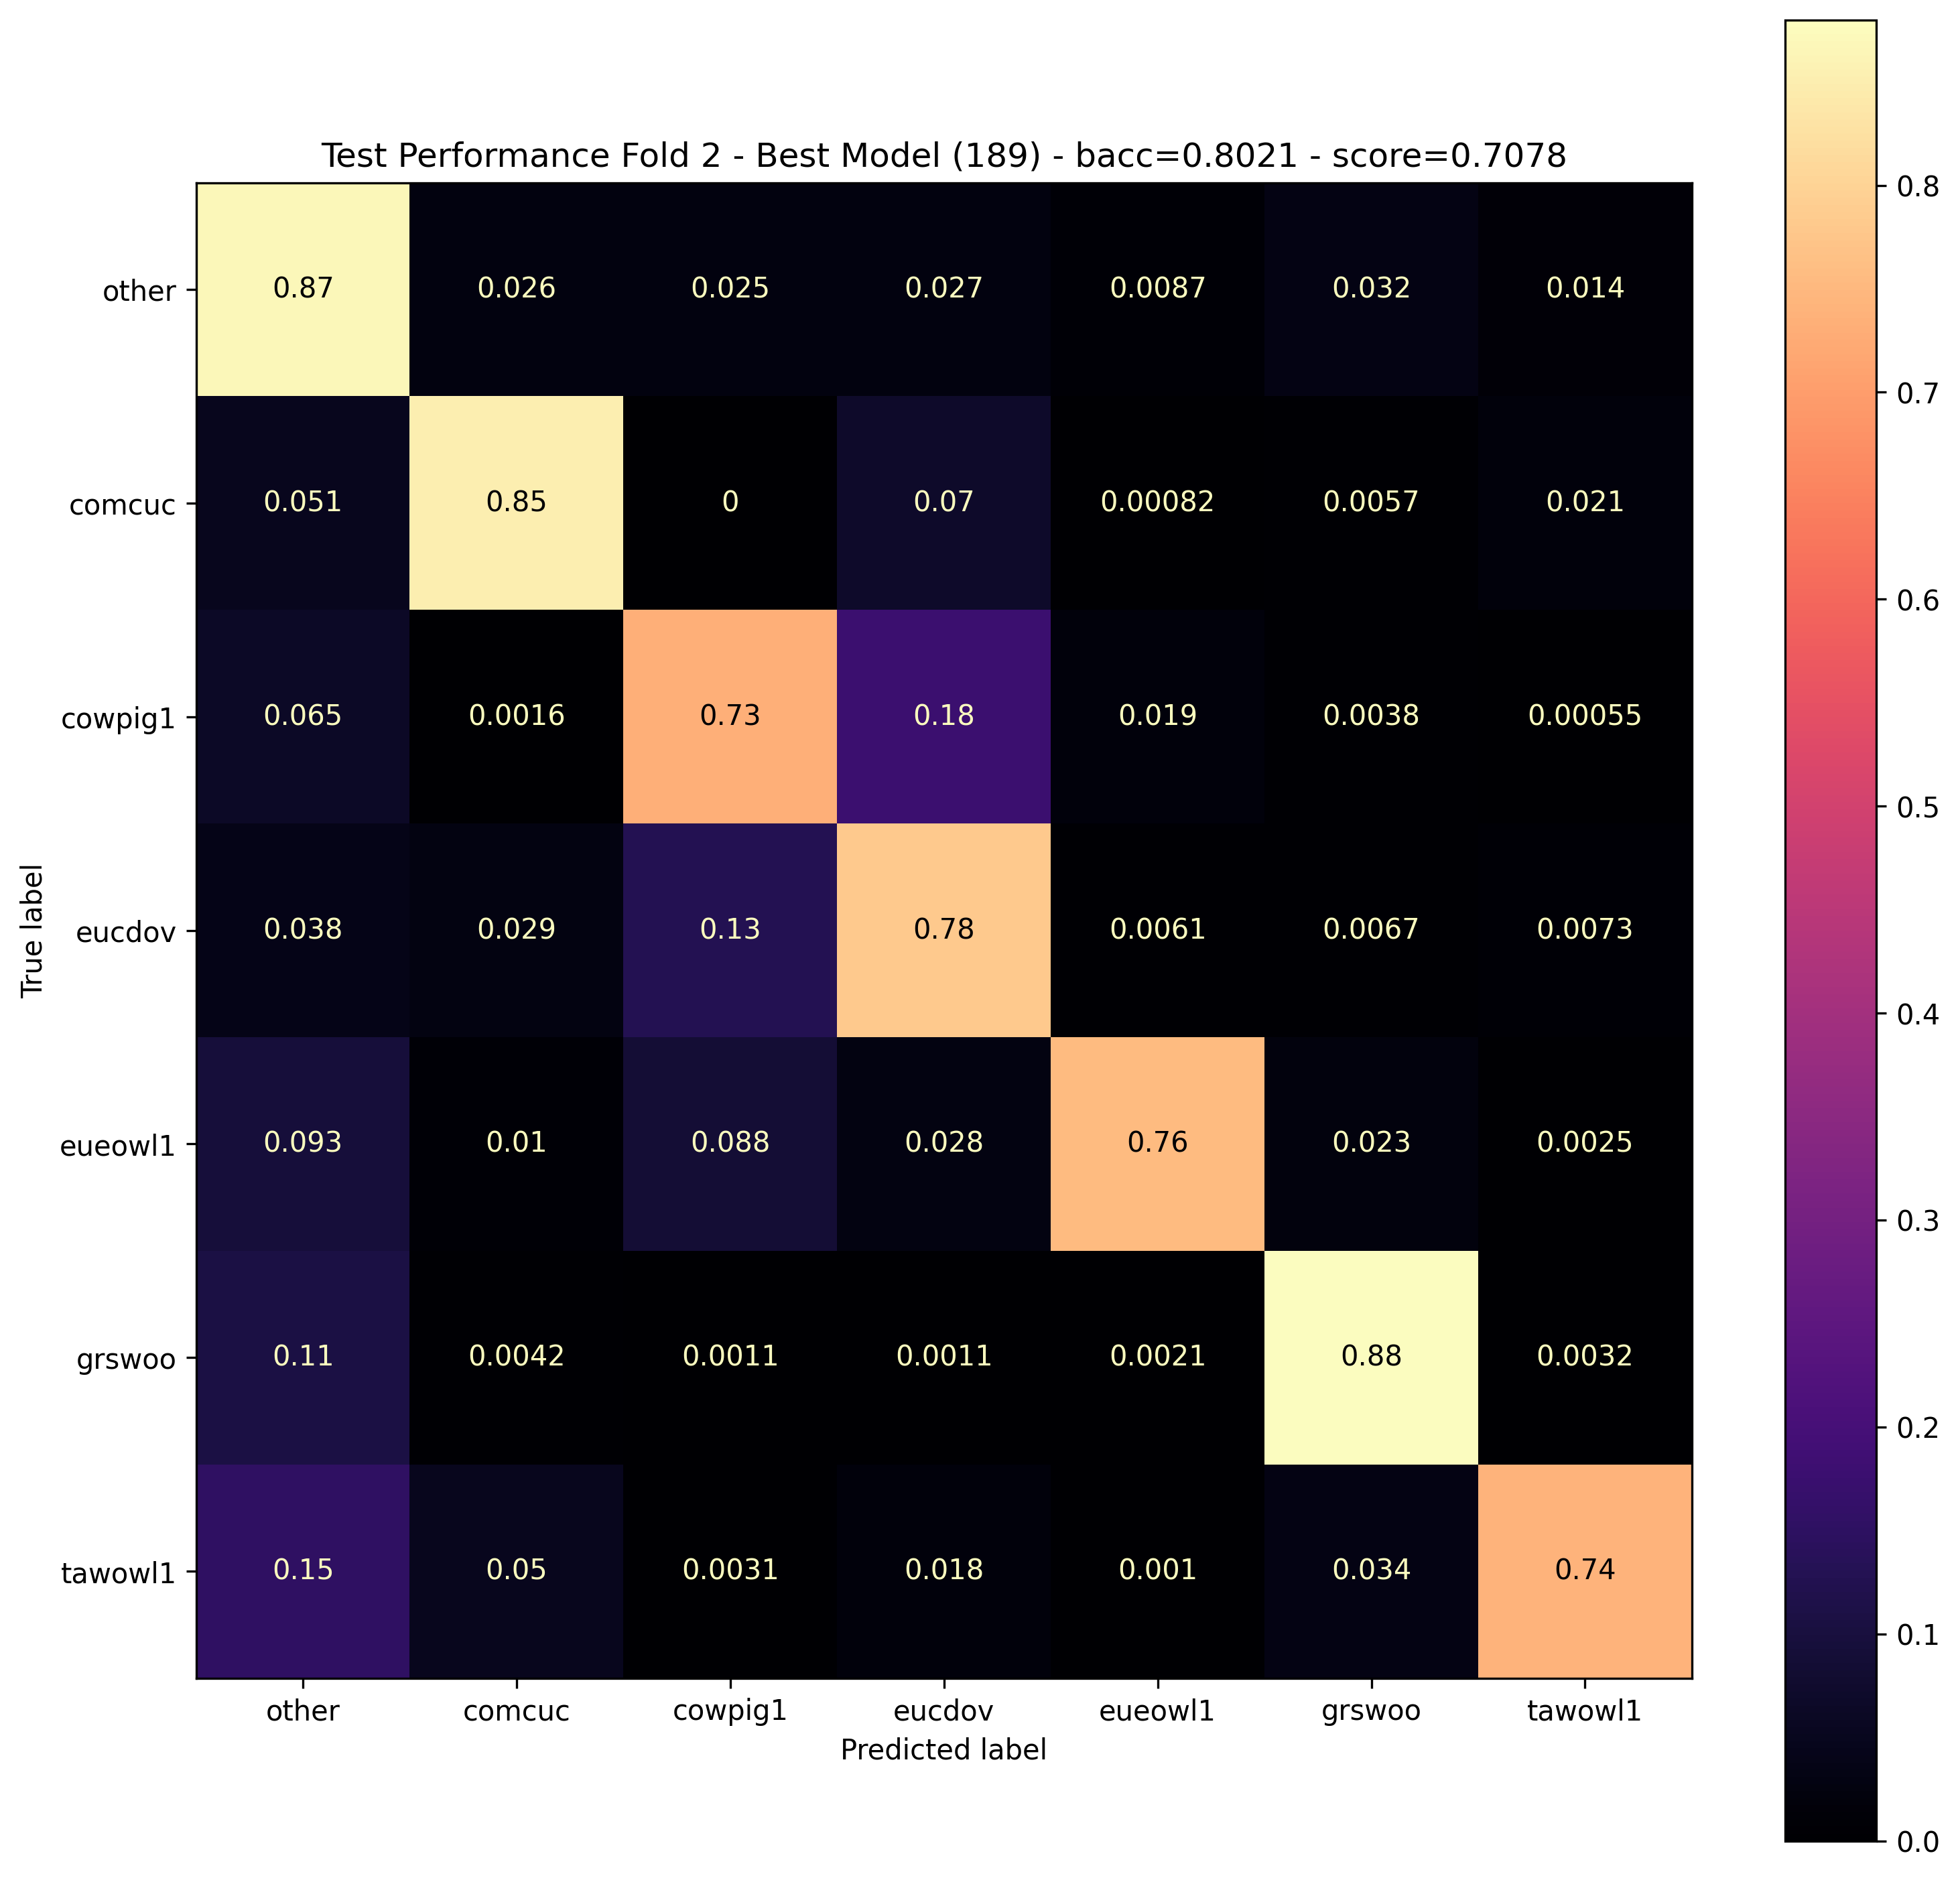

CV Folds:  38%|███████████████████████████████████████████████████████████████                                                                                                         | 3/8 [02:17<03:47, 45.53s/it]

Best Model Test Metrics: avg_loss = 0.000115, num_samples = 24000, num_correct = 20274, acc = 0.844750, bacc = 0.802131, score = 0.707848
Saved model with scaler as "species_classifier cv2023-06-08_16.51 fold-2-best eval-score=0.8082 test-score=0.7078 "



Executing CV for fold 3
Training fold 3


#### Training ####
##################
AttentionClassifier with 57819 parameters, in_fnn: 41196, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [59829,  4033,  6286,  5783,  1723,  3575,  2771]
train label counts = [ 8537,   581,   839,   781,   205,   586,   471]

loss weights                    = [ 0.74, 14.83,  6.35, 10.35, 34.72, 16.74, 21.59]
eval loss weights (theoretical) = [ 0.74, 14.69,  6.78, 10.93, 41.64, 14.57, 18.13]


Training Epoch   1/200: lr = 1.00E-03, epoch =     1, avg_loss = 0.000209, num_samples = 84000, num_correct =  4006, acc = 0.047690, bacc = 0.143743, score = -0.368236
Evaluation Epoch   1/200: epoch =     1, avg_loss = 0.000342, num_

CV Folds:  38%|███████████████████████████████████████████████████████████████                                                                                                         | 3/8 [02:39<04:26, 53.28s/it]

Training Epoch 109/200: lr = 1.00E-03, epoch =   109, avg_loss = 0.000014, num_samples = 84000, num_correct = 73518, acc = 0.875214, bacc = 0.957503, score = 0.879851
Evaluation Epoch 109/200: epoch =   109, avg_loss = 0.000084, num_samples = 12000, num_correct = 10263, acc = 0.855250, bacc = 0.889410, score = 0.805142


KeyboardInterrupt: 

In [ ]:
set_random_seed(43)

cv_training_hyper_parameters = create_training_hyper_parameters(
    num_epochs=200,
    initial_lr=1e-3,
    
    lr_scheduler_milestones=[30, 100, 250],
    lr_scheduler_gamma=0.75,
)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_model_with_cv(
    lambda: AttentionClassifier(ac_hyper_parameters),
    cv_training_hyper_parameters, 
    sequences_ds_train,
    sequences_ds_test,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='species_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

cv_average_best_best_models_test_metrics = calculate_average_metrics([m[3] for m in best_models_metrics])
print(f'{cv_average_best_best_models_test_metrics = } \n\n')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

# Plots

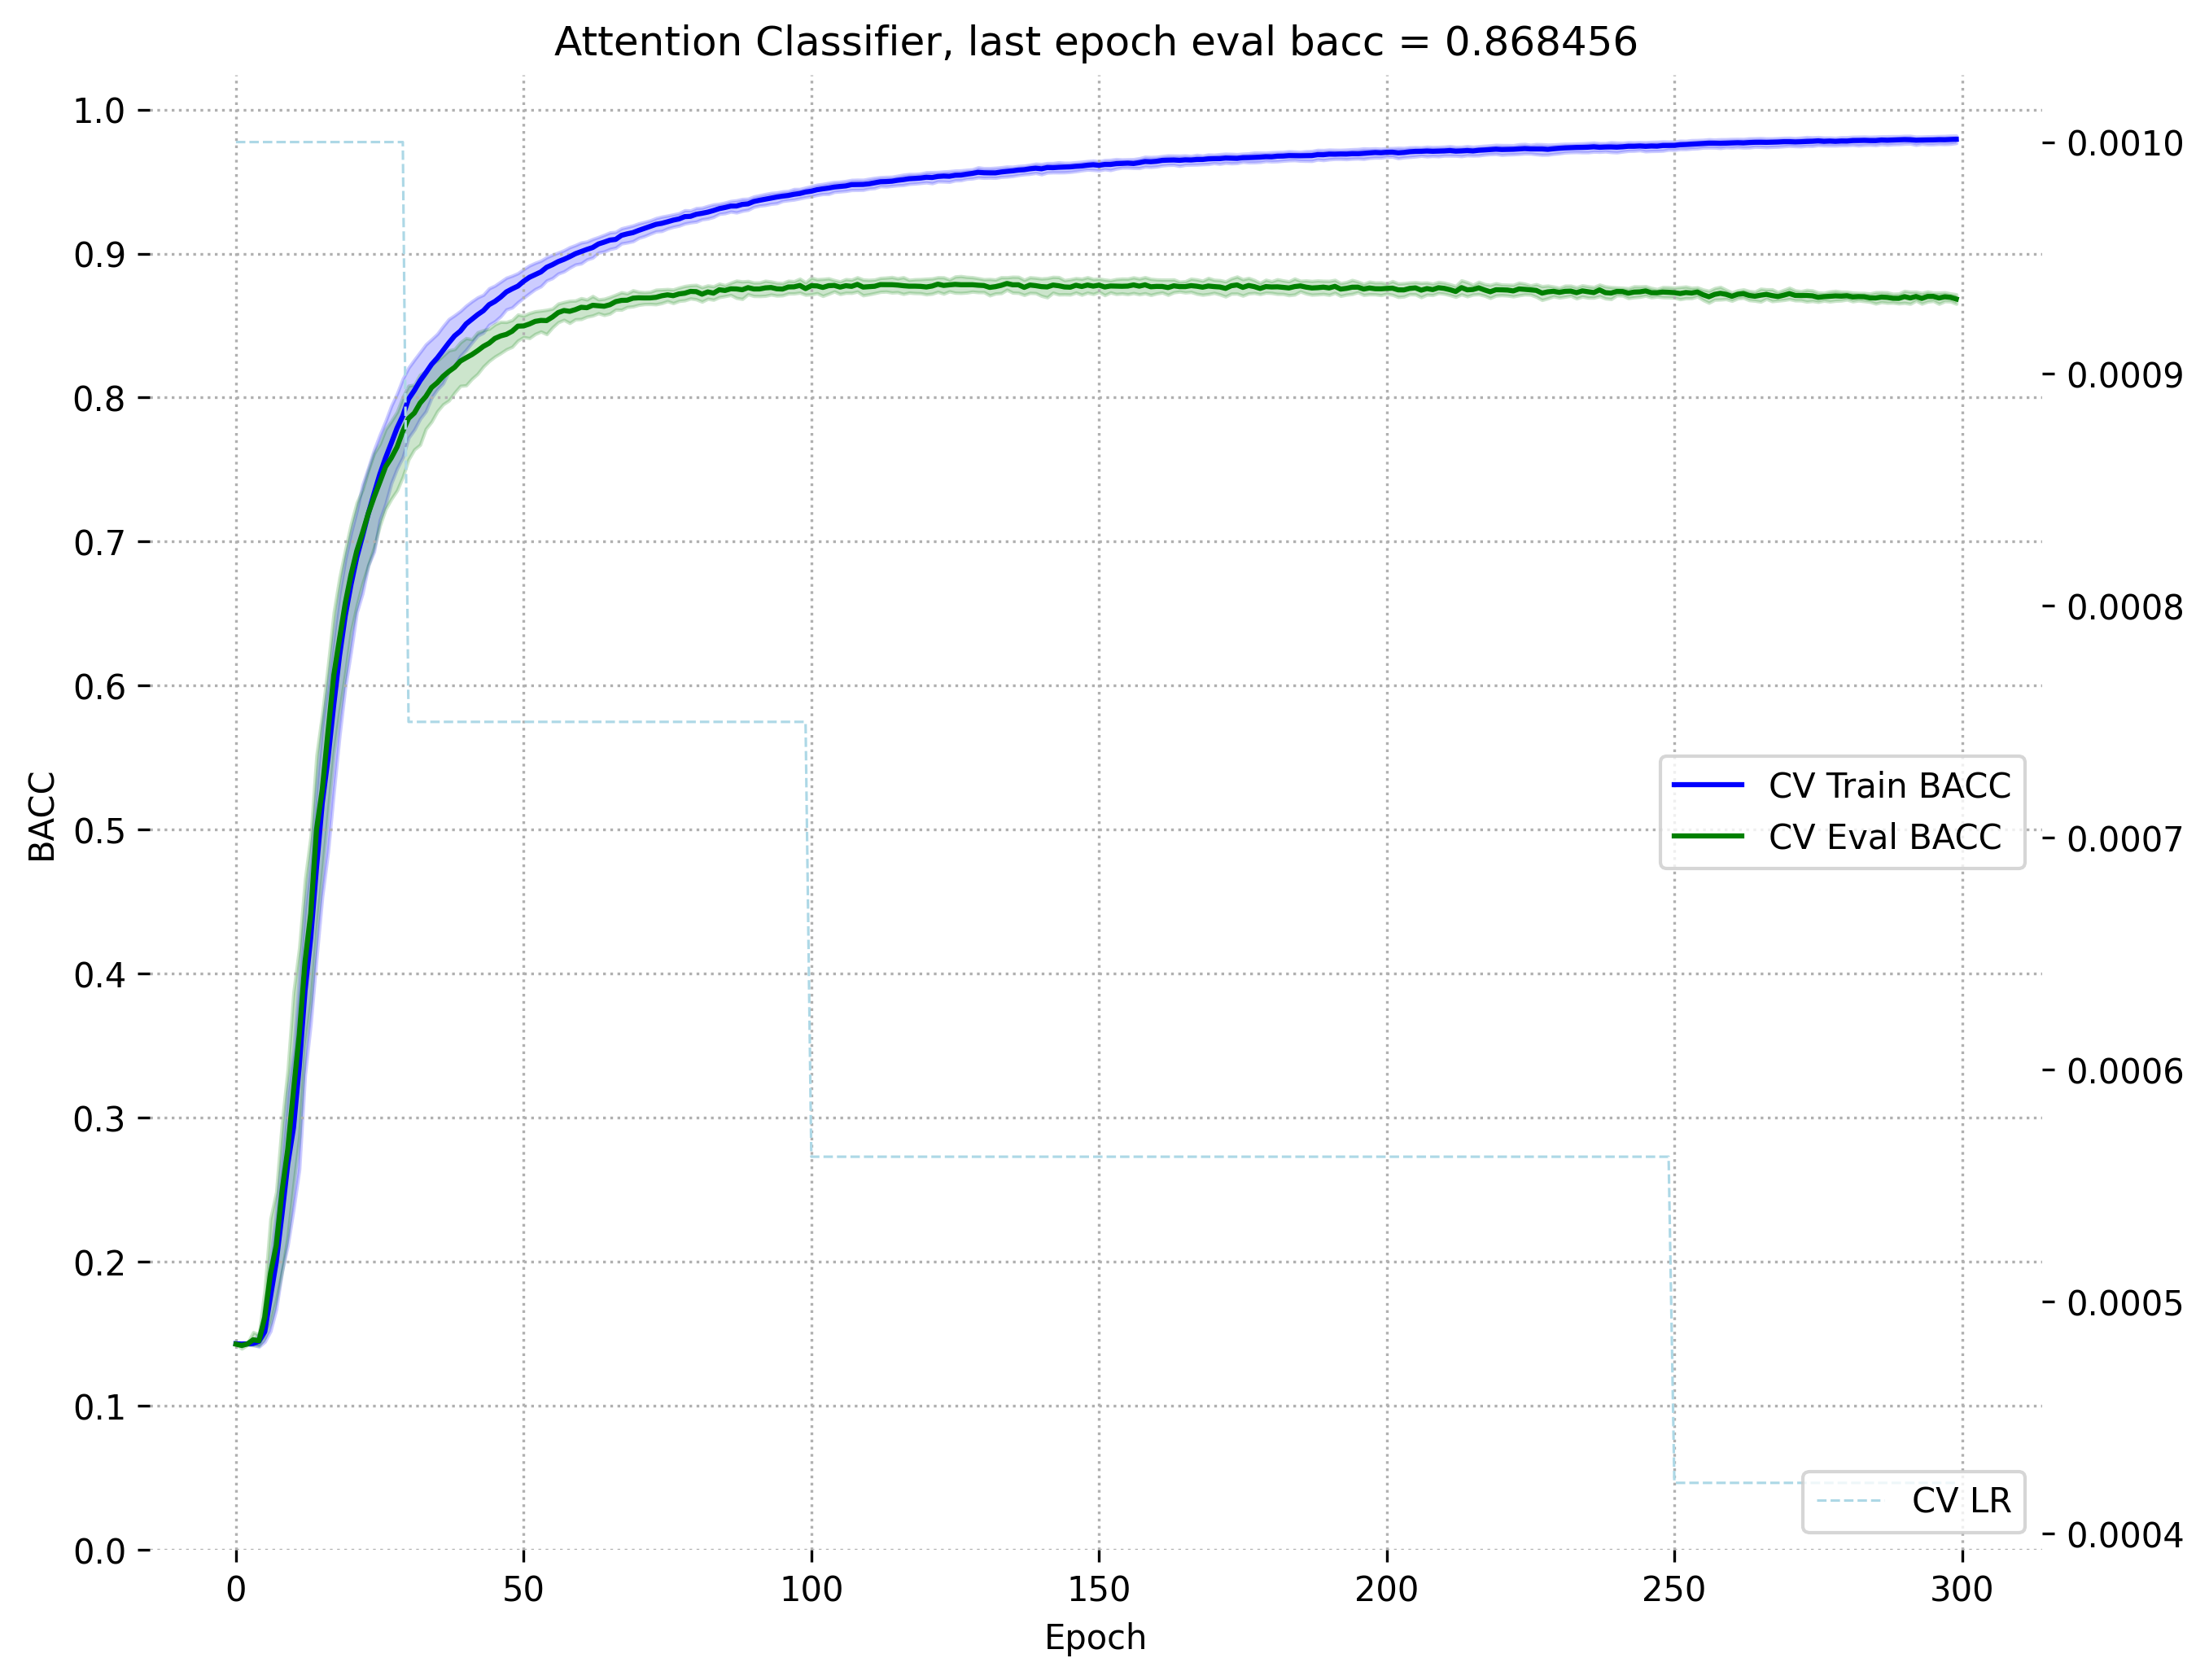

In [25]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')